# <font size="6"> Machine Learning Regression Models for Uber and Lyft Prices: </font>

<font size="5"> - Automating Hypertuning, Testing, and Analysis of Models for Custom Data Subsets </font>


## Project Overview

### Objective

The primary purpose of this project was to build several machine learning algorithms for predicting the price of Uber and Lyft ride fares. Testing of various algorithms would help me uncover the relative impact of different predictor variables on price. The ML models I explored in-depth were simple/multivariate/polynomial regression, k-Nearest Neighbor Regresion, Random Forest Regression, and Gradient-Boosted Regression. I also briefly tested Decision Trees and Ada-Boost Regression. 

A secondary purpose of this project was to automate the creation of these models against user-defined cross-stratifications of the dataset. For example, one may want to see how ML models performed on only Uber rides vs. only Lyft Rides, among only ride types that are "XL". Once these (and other) stratum parameters are defined, the notebook will recreate all exploratory analysis, visualizations, and ML model creations - each being optimally hypertuned. The final result will be a dataframe that compare various performance metrics of each regression model. My commentary on analysis within this notebook is specific to results with the global parameters defined below. With minimal modifications, my hope is that this notebook can serve as a rough template for regression analysis done on other datasets.

### Description of Dataset

This dataset, pulled from [Kaggle](https://www.kaggle.com/ravi72munde/uber-lyft-cab-prices), has ~700,000 records of Uber and Lyft rides with information on price, surge-multipler for price, time, distance, weather, and other various data features. As many have experienced first-hand, Ride Share prices tend to surge when there is high rider demand and/or low supply of drivers. While distance of the ride is surely a major predictor of the Ride Share fare, my hypothesis is that weather (i.e temperature, wind, etc.), time of day, and day of the week will also have an impact on rider demand - and therefore prices 

#### User-Defined Global Parameters for All Analysis ML Model Development

I defined my data subsets of interest in the global parameters below. These parameters will be inovked into each of my machine learning models, and these models will be hyptertuned accordingly. In this instance, I wanted to look at both Uber and Lyft combined, for only 'Standard' rides (i.e. UberX, Lyft Standard'). 

Assuming that ride distance and surge-multiplier are two the of the main determinants of price, I wanted to make sure that my dataset had a good distribution of records with a 'surged' price. This way, I could indirectly discover which factors caused the biggest rider demand surges. Unfortunately, this turned out to be very far from the truth. After some exploration of the data (more on this below), I learned that only a small proportion of records that had any surge-multipler. 

My exploratory analysis (discussed below) showed that there are very few records with surge pricing. The paramater below gives the option to only filter on records that have a surge_multiplier > 1. Doing so may give a better indicator of factors (besides distance) that may impact price.

In [ ]:
remove_nonsurge_pricing = 'Y'

The parameter above specifies whether the dataset should ONLY include records that have a surge-multiplier > 1 (indicated by 'Y'). I chose to filter on these records because I was particularly curious to see which features besides distance impacted price. I was concerned that keeping all records would be overly (and unrealistically) representative of rides in conditions with baseline rider demand. Anyone that's ever order an Uber/Lyft can likely agree that surge-pricing occurrs fairly frequently. I was also concerned that under-representing surge-priced rides would give bias to distance as the key predictor of ride prices. These are, of course, only assumptions, and the ML models can easily be re-generated with updated global parameters.

The downside of filtering of rides with surged price is that it drastically reductes the number of records (more on this below). Also, I learned that none of the Uber ride records had a surged price, and only some of the ride types for Lyft. This leads to my next set of global parameters.



The cab_type variable is for defining whether to filter only on Uber or Lyft rides. Since there are no Uber records with surge-pricing (filtered above), I am forced to filter on Lyft-only rides. I chose to focus on only 'Standard' Lyft rides because I think other ride types (like Lyft XL or 'Luxury') would have different pricing rates, which would adversely affect the accuracy of my ML models. It's possible to filter on multiple ride types, but there were no 'Shared' rides with a surge-pricing. Therefore, it cannot be selected if the remove_nonsurge_pricing filter is set to 'Y'.

In [45]:
cab_type_global = ['Lyft'] #If filtering 'Y' on 'remove_nonsurge_pricing', then Uber cannot be selected
ride_type_global = ['Standard'] # If filtering 'Y' on 'remove_nonsurge_pricing', then 'Shared' cannot be selected

For computational efficiency purposes, I decided on my predictor variables of interest upfront (justification of choosing these is explained later). I also wanted to compare how my ML models would perform using only one predictor variable. I chose 'distance' below, because I assumed this would be the most significant predictor. 

Price is my target variable of interest, but I chose to make this user-defined as well. One could possibly explore other target variables such as 'price per mile' or 'surge multiplier'. 


In [46]:
predictors = ['distance','temperature','precipIntensity', 'humidity', 'windSpeed', 'time', 'weekday'] #predictor variables
target = ['price'] ##target variable
single_var = ['distance'] #predictor variable for simple ML models with one variable
all_variables = predictors + target ##used as input for ML Class Functions below

In this parameter, you can specify the proportion of records you'd like to sample, after the filter above is applied. The raw dataset is very large (nearly 700K rows).  I've chosen to keep this at 100% since I'm already filter on rows with surge pricing. If choosing 'N' above, it may be wise to sample only a subset.

In [47]:
sample_size_pct = 1

## Data Pre-Processing and Exploration

My exploratory analysis (discussed below) showed that there are very few records with surge pricing. The paramater below gives the option to only filter on records that have a surge_multiplier > 1. Doing so may give a better indicator of factors (besides distance) that may impact price.

In [48]:
remove_nonsurge_pricing = 'Y'

Now, onto the data exploration and pre-processing! First, we'll import some basic libraries, and and our csv dataset.

In [49]:
import numpy as np
import pandas as pd
import os

In [50]:
os.chdir("C:\\Users\\oshapira\\Desktop\\Analytics\\Uber\\data")
##import dataset and create data frame
df_raw = pd.read_csv('rideshare_kaggle.csv')


Then, we'll look at the dataset dimensions, and a snapshot of the data.

In [51]:
pd.set_option('display.max_columns', 100) ##set option to display all columns
df_dimensions = print('Dataset dimensions' + str(df_raw.shape))
df_dimensions

df_raw.head(5)


Dataset dimensions(693071, 57)


id     timestamp  hour  day  month  \
0  424553bb-7174-41ea-aeb4-fe06d4f4b9d7  1.544953e+09     9   16     12   
1  4bd23055-6827-41c6-b23b-3c491f24e74d  1.543284e+09     2   27     11   
2  981a3613-77af-4620-a42a-0c0866077d1e  1.543367e+09     1   28     11   
3  c2d88af2-d278-4bfd-a8d0-29ca77cc5512  1.543554e+09     4   30     11   
4  e0126e1f-8ca9-4f2e-82b3-50505a09db9a  1.543463e+09     3   29     11   

              datetime          timezone            source    destination  \
0  2018-12-16 09:30:07  America/New_York  Haymarket Square  North Station   
1  2018-11-27 02:00:23  America/New_York  Haymarket Square  North Station   
2  2018-11-28 01:00:22  America/New_York  Haymarket Square  North Station   
3  2018-11-30 04:53:02  America/New_York  Haymarket Square  North Station   
4  2018-11-29 03:49:20  America/New_York  Haymarket Square  North Station   

  cab_type    product_id          name  price  distance  surge_multiplier  \
0     Lyft     lyft_line        Shared    5.0      0.44               1.0   
1     Lyft  lyft_premier           Lux   11.0      0.44               1.0   
2     Lyft          lyft          Lyft    7.0      0.44               1.0   
3     Lyft   lyft_luxsuv  Lux Black XL   26.0      0.44               1.0   
4     Lyft     lyft_plus       Lyft XL    9.0      0.44               1.0   

   latitude  longitude  temperature  apparentTemperature    short_summary  \
0   42.2148    -71.033        42.34                37.12   Mostly Cloudy    
1   42.2148    -71.033        43.58                37.35            Rain    
2   42.2148    -71.033        38.33                32.93           Clear    
3   42.2148    -71.033        34.38                29.63           Clear    
4   42.2148    -71.033        37.44                30.88   Partly Cloudy    

                                        long_summary  precipIntensity  \
0                          Rain throughout the day.            0.0000   
1   Rain until morning, starting again in the eve...           0.1299   
2                        Light rain in the morning.            0.0000   
3                 Partly cloudy throughout the day.            0.0000   
4                 Mostly cloudy throughout the day.            0.0000   

   precipProbability  humidity  windSpeed  windGust  windGustTime  visibility  \
0                0.0      0.68       8.66      9.17    1545015600      10.000   
1                1.0      0.94      11.98     11.98    1543291200       4.786   
2                0.0      0.75       7.33      7.33    1543334400      10.000   
3                0.0      0.73       5.28      5.28    1543514400      10.000   
4                0.0      0.70       9.14      9.14    1543446000      10.000   

   temperatureHigh  temperatureHighTime  temperatureLow  temperatureLowTime  \
0            43.68           1544968800           34.19          1545048000   
1            47.30           1543251600           42.10          1543298400   
2            47.55           1543320000           33.10          1543402800   
3            45.03           1543510800           28.90          1543579200   
4            42.18           1543420800           36.71          1543478400   

   apparentTemperatureHigh  apparentTemperatureHighTime  \
0                    37.95                   1544968800   
1                    43.92                   1543251600   
2                    44.12                   1543320000   
3                    38.53                   1543510800   
4                    35.75                   1543420800   

   apparentTemperatureLow  apparentTemperatureLowTime                   icon  \
0                   27.39                  1545044400   partly-cloudy-night    
1                   36.20                  1543291200                  rain    
2                   29.11                  1543392000           clear-night    
3                   26.20                  1543575600           clear-night    
4                   30.29                

In [52]:
df_raw.columns

Index(['id', 'timestamp', 'hour', 'day', 'month', 'datetime', 'timezone',
       'source', 'destination', 'cab_type', 'product_id', 'name', 'price',
       'distance', 'surge_multiplier', 'latitude', 'longitude', 'temperature',
       'apparentTemperature', 'short_summary', 'long_summary',
       'precipIntensity', 'precipProbability', 'humidity', 'windSpeed',
       'windGust', 'windGustTime', 'visibility', 'temperatureHigh',
       'temperatureHighTime', 'temperatureLow', 'temperatureLowTime',
       'apparentTemperatureHigh', 'apparentTemperatureHighTime',
       'apparentTemperatureLow', 'apparentTemperatureLowTime', 'icon',
       'dewPoint', 'pressure', 'windBearing', 'cloudCover', 'uvIndex',
       'visibility.1', 'ozone', 'sunriseTime', 'sunsetTime', 'moonPhase',
       'precipIntensityMax', 'uvIndexTime', 'temperatureMin',
       'temperatureMinTime', 'temperatureMax', 'temperatureMaxTime',
       'apparentTemperatureMin', 'apparentTemperatureMinTime',
       'apparentTemperat

Whoah, that's a lot of columns! Let's clean things up a bit for simplified analysis. But before that, let's add some new derived variables of interest.

### Preliminary Data Manipulation

#### Derive Weekday Values

While this dataset contained a timestamp variable, it did not include day of week - one of my variables of interest. This was derived below.

In [53]:
df = df_raw.copy()
##create new datetime column that is in date_time format
df['datetime_2'] = pd.to_datetime(df.datetime, format="%Y-%m-%d %H:%M:%S") ##convert datetime to datetime format

##add variable for day of week for given ride
##sunday = 6, monday = 0
df['weekday'] = [x.weekday() for x in df['datetime_2']]

dict_weekday = {0: 'Monday', 1: 'Tuesday', 2: 'Wednesday', 3: 'Thursday', 4: 'Friday', 5: 'Saturday', 6: 'Sunday'} 
#map weekday values to weekday text strings

df['weekday'] = df['weekday'].map(dict_weekday).fillna(df['weekday'])

#### Clean up and convert time stamp variables

Furthermore, the timestamp included is reflective of calendar date. My interest was whether price fluctuated by time of day. Therefore, I had to derive the timestamp within each day. The reulting column is minutes elapsed from the start of the day as a numeric value.

In [54]:
from datetime import datetime

####extract precise hour and minute of day from datetime variable
df['time']= [datetime.strptime(x, '%Y-%m-%d %H:%M:%S') for x in df['datetime']] ##create new timestamp column

df['time'] = [x.time() for x in df['time']] #extract time of day
df['time'] = [x.hour*60+x.minute+x.second/60 for x in df['time']]
df['time'].head(6)


0     570.116667
1     120.383333
2      60.366667
3     293.033333
4     229.333333
5    1105.200000
Name: time, dtype: float64

#### Add 'Price Per Mile' Varible

I also added a derived column for price per mile. This would help me detect outlier datapoints (seen below). It could also serve as a potential target variable (defined in global parameter above) for subsequent ML model comparison.

In [55]:
df['ppm'] = df['price']/df['distance']

### Analyze Data Distribution

Next, I wanted to analyze the disribution of each of the dataset variables. This would help me get a feel for potential anamolies, redundant variables, and any skewed distributions

There are a few very significant takeways from the summary statistics below:
1. The vast majority of rides do not have any surge multipler. This made me concerned that prices would be solely reflected by distance rather than other factors that may drive up rider demand (and therefore price).  
2. This dataset only includes rides in November/December,and therefore the temperature range is fairly small (40 - 60 degrees). I now suspect that temperature will have minimal impact on whether someone decides between walking vs. ordering a Lyft/Uber. It would have been more ideal if this data included additional warmer months for comparison. 
3. Both price and price/per mile have some very high max values. There may be some outliers that need exploration
4. Time of day seems to have an even distribution (i.e. 12pm is the median value)

In [56]:
print(df.describe())

          timestamp           hour            day          month  \
count  6.930710e+05  693071.000000  693071.000000  693071.000000   
mean   1.544046e+09      11.619137      17.794365      11.586684   
std    6.891925e+05       6.948114       9.982286       0.492429   
min    1.543204e+09       0.000000       1.000000      11.000000   
25%    1.543444e+09       6.000000      13.000000      11.000000   
50%    1.543737e+09      12.000000      17.000000      12.000000   
75%    1.544828e+09      18.000000      28.000000      12.000000   
max    1.545161e+09      23.000000      30.000000      12.000000   

               price       distance  surge_multiplier       latitude  \
count  637976.000000  693071.000000     693071.000000  693071.000000   
mean       16.545125       2.189430          1.013870      42.338172   
std         9.324359       1.138937          0.091641       0.047840   
min         2.500000       0.020000          1.000000      42.214800   
25%         9.000000       

The histogram below validates my concern of a very uneven distribution of rides with 'surge' pricing.

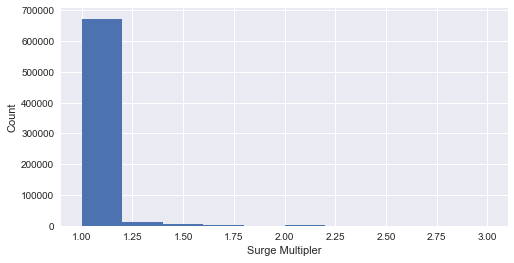

In [57]:
import matplotlib.pyplot as plt
%matplotlib inline
from IPython.display import display, HTML
display(HTML("<style>div.output_scroll { height: 44em; }</style>")) ##Turn off scrollable output

plt.figure(figsize = (8, 4))
df['surge_multiplier'].hist()
plt.xlabel('Surge Multipler')
plt.ylabel('Count')
plt.show()

The if-function below filters only on records that have a surge-multiplier greater than 1. 

In [58]:
if remove_nonsurge_pricing == 'Y':
    df = df[df['surge_multiplier'] > 1]    
else:
    pass

print("There are " + str(len(df)) + " records remaining in this dataset") ##number of records remaining

There are 20975 records remaining in this dataset


The remaining records still have a surge_multiplier distribution that is skewed right, but is much better than the raw dataset.

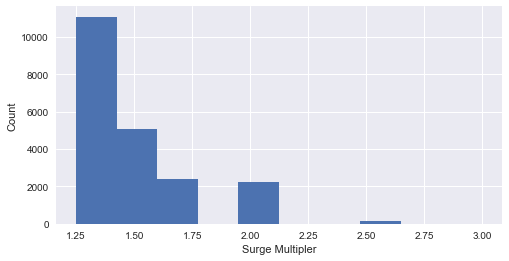

In [59]:
plt.figure(figsize = (8, 4))
df['surge_multiplier'].hist()
plt.xlabel('Surge Multipler')
plt.ylabel('Count')
plt.show()

#### Reducing DataFrame Dimensions

Once these derived columns for analysis were added, I focused my data exploration on features that I believed had the most likely impact on price. There were many features in the dataset that seeemed redundant or unrelated to my ultimate goal of predicting ride price.


In [60]:
###initial filtering of columns desired for analysis

columns_to_keep_eda = ['price','ppm', 'hour', 'time', 'distance', 'surge_multiplier', 'temperature','precipIntensity', 'humidity', 'windSpeed']
df_eda = df.filter(items = columns_to_keep_eda)

#### Distribution of Categorical Variables

The first variable I explored was the distribution of ride types (i.e. Uber XL, Lyft Pool, Uber Black, etc.). As mentioned, I wanted to have the flexibility to compare my ML models filtered on different Cab Types and Ride Types. 

In [61]:
df.groupby(['cab_type', 'name'])['name'].count()

cab_type  name        
Lyft      Lux             4195
          Lux Black       4195
          Lux Black XL    4195
          Lyft            4195
          Lyft XL         4195
Name: name, dtype: int64

Another significant finding: When filtering on rides with a surge multiplier > 1, all Uber records have been removed. This unfortunately limits some of our cross-comparison ability between Uber and Lyft!

In case our global parameter was set to include non-surge priced rides, I provied a bar chart of ride type distribution below. I also mapped the distinct source products into three buckets - 'Standard', 'Luxury', and 'XL'. This would group together ride types that should have similar prices, while also normalizing the distinct product types between Uber and Lyft.

In [62]:
###create column for ride types so that Uber and Lyft can be more comparable
types=list(df.name.unique())

types_map = {'Shared':'Shared', 'Lux':'Luxury', 'Lyft':'Standard', 
             'Lux Black XL': 'Luxury', 'Lyft XL':'XL', 'Lux Black':'Luxury', 'UberXL':'XL', 
             'Black':'Luxury', 'UberX':'Standard', 'WAV':'Luxury', 'Black SUV':'Luxury', 'UberPool':'Shared', 
             'Taxi':'Luxury'}

df['ride_type'] = df['name'].map(types_map).fillna(df['name'])

In [63]:
df.groupby(['cab_type', 'ride_type'])['name'].count()

cab_type  ride_type
Lyft      Luxury       12585
          Standard      4195
          XL            4195
Name: name, dtype: int64

C:\Users\oshapira\AppData\Local\Continuum\Anaconda3\lib\site-packages\seaborn\categorical.py:1428: FutureWarning: remove_na is deprecated and is a private function. Do not use.
  stat_data = remove_na(group_data)


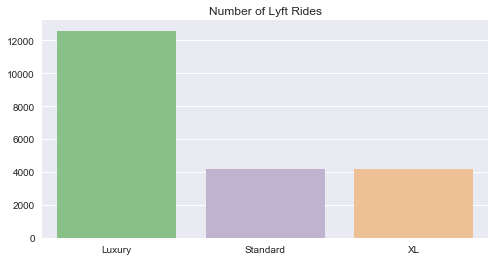

In [64]:
import seaborn as sns

if remove_nonsurge_pricing == 'N':
    
    h, axes = plt.subplots (1,3, figsize=(20,6))


    Both =df.cab_type.unique()
    Ux=df.ride_type[df.cab_type=='Uber'].unique()
    Lx=df.ride_type[df.cab_type=='Lyft'].unique()

    Uy = []
    for i in range(0, len(Ux)):
        val = Ux[i]
        values = df.ride_type[df.ride_type == val].count()
        Uy.append(values)

    Ly = []
    for i in range(0, len(Lx)):
        val = Lx[i]
        values = df.ride_type[df.ride_type == val].count()
        Ly.append(values)

    cabtype = []
    for i in range(0, len(Both)):
        val = Both[i]
        values = (df.name == val).count()
        cabtype.append(values)


    vis1= sns.barplot(Ux,np.array(Uy),palette='Accent',ax=axes[0])
    vis2= sns.barplot(Lx,np.array(Ly),palette='Accent',ax=axes[1])
    vis3= sns.barplot(Both,np.array(cabtype),palette='Accent',ax=axes[2])


    axes[0].set_title('Number of Uber Rides')
    axes[1].set_title('Number of Lyft Rides')
    axes[2].set_title('Counts by Cab Type')
    plt.ioff()
    
else:
    plt.figure(figsize = (8, 4))
    Lx=df.ride_type[df.cab_type=='Lyft'].unique()

    Ly = []
    for i in range(0, len(Lx)):
        val = Lx[i]
        values = df.ride_type[df.ride_type == val].count()
        Ly.append(values)
    vis1= sns.barplot(Lx,np.array(Ly),palette='Accent')

    plt.title('Number of Lyft Rides')
    plt.ioff()

The next categorical variable I looked at was weekdays. The distribution of these seemed fairly even.

In [65]:
df.groupby(['cab_type', 'weekday'])['name'].count()

cab_type  weekday  
Lyft      Friday       2655
          Monday       3743
          Saturday     2733
          Sunday       2725
          Thursday     3013
          Tuesday      3836
          Wednesday    2270
Name: name, dtype: int64

First, I wanted to display any rows with NA values that may need to be removed. If there were any, I removed them.

In [66]:
df_eda[df_eda.isna().any(axis=1)]


Empty DataFrame
Columns: [price, ppm, hour, time, distance, surge_multiplier, temperature, precipIntensity, humidity, windSpeed]
Index: []

In [67]:
df_eda = df_eda.dropna() #drop NAs

Next, I retrived summary statistics on my updated dataset, which has been filtered down in width and length. I also created a boxplot.

In [68]:
df_eda.describe()

price           ppm          hour          time      distance  \
count  20975.000000  20975.000000  20975.000000  20975.000000  20975.000000   
mean      27.836949     13.885669     11.600095    725.206362      2.342596   
std       13.968720      9.378592      6.980854    419.115294      1.041785   
min        7.000000      2.786378      0.000000      0.066667      0.390000   
25%       16.500000      8.125000      6.000000    360.108333      1.470000   
50%       26.000000     11.607143     12.000000    740.133333      2.390000   
75%       38.000000     16.520781     18.000000   1085.183333      3.040000   
max       97.500000    114.130435     23.000000   1439.116667      6.120000   

       surge_multiplier   temperature  precipIntensity      humidity  \
count      20975.000000  20975.000000     20975.000000  20975.000000   
mean           1.458296     39.503945         0.008712      0.739257   
std            0.271701      6.717298         0.026635      0.137660   
min            1.250000     18.910000         0.000000      0.380000   
25%            1.250000     36.270000         0.000000      0.640000   
50%            1.250000     40.470000         0.000000      0.710000   
75%            1.500000     43.570000         0.000000      0.880000   
max            3.000000     57.220000         0.144700      0.960000   

          windSpeed  
count  20975.000000  
mean       6.205639  
std        3.133629  
min        0.450000  
25%        3.410000  
50%        5.920000  
75%        8.410000  
max       15.000000

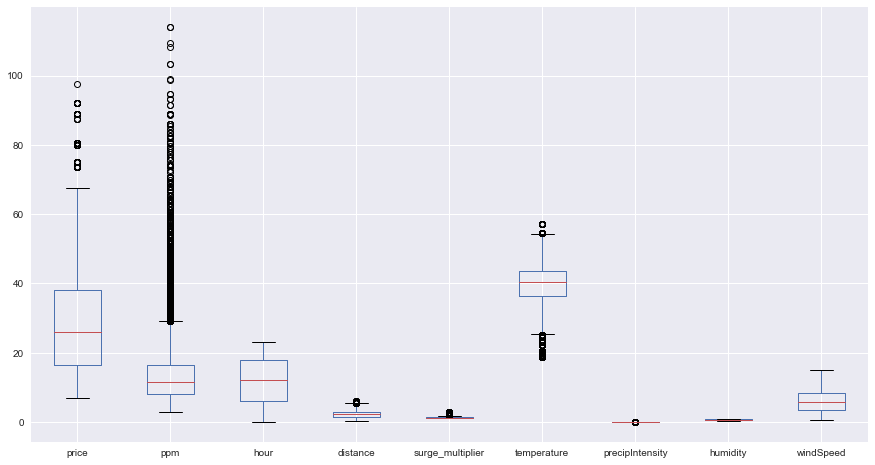

In [69]:
columns_to_keep_box = ['price','ppm', 'hour', 'distance', 'surge_multiplier', 'temperature','precipIntensity', 'humidity', 'windSpeed']
df_box = df.filter(items = columns_to_keep_box) ##removed 'time' from boxplot

import matplotlib.pyplot as plt
%matplotlib inline

plt.figure(figsize = (15, 8))
df_box.boxplot()

Right away, I see that there were many unusually high values for 'ppm' (price per mile). I decided to further explore data points where the price per mile was > $50. At a glance, it seems like these belong to 'Lux Black XL' rides - the most expensive types. There were also only 250 records like this, so I decided to leave in this suspected outliers.

In [70]:
outliers = df[df['ppm'] > 50]
outliers = outliers.filter(items = ['price','ppm', 'hour', 'distance', 'surge_multiplier', 'temperature','precipIntensity', 'humidity', 'windSpeed', 'name'])
print("There are " + str(len(df[df['ppm'] > 50])) + " outlier records")
outliers.head(10)

There are 250 outlier records


price        ppm  hour  distance  surge_multiplier  temperature  \
1331    27.5  59.782609     4      0.46              1.75        34.38   
1333    45.5  98.913043     8      0.46              1.75        45.69   
3920    32.5  67.708333     4      0.48              1.25        34.81   
7701    34.0  53.968254    23      0.63              1.25        41.43   
7825    38.5  58.333333     4      0.66              1.50        47.71   
10561   32.5  50.781250    21      0.64              1.25        41.35   
13371   34.0  53.968254    12      0.63              1.25        27.93   
15137   32.5  58.035714    17      0.56              1.25        40.77   
16299   32.5  53.278689     9      0.61              1.25        46.62   
17779   45.5  64.084507     1      0.71              1.75        45.96   

       precipIntensity  humidity  windSpeed          name  
1331            0.0000      0.73       5.28     Lux Black  
1333            0.0000      0.95       1.05  Lux Black XL  
3920            0.0000      0.77       2.98  Lux Black XL  
7701            0.0000      0.79       3.73  Lux Black XL  
7825            0.0013      0.94       2.45  Lux Black XL  
10561           0.0000      0.60       9.29  Lux Black XL  
13371           0.0000      0.81       2.69  Lux Black XL  
15137           0.0000      0.63       8.76  Lux Black XL  
16299           0.0000      0.88       3.52  Lux Black XL  
17779           0.0000      0.61       5.65  Lux Black XL

I then re-displayed the boxplot with removed outliers. 

Since the scale made some variables difficult to interpret, I also created histograms for each variable of interest.

<Figure size 1800x1080 with 0 Axes>

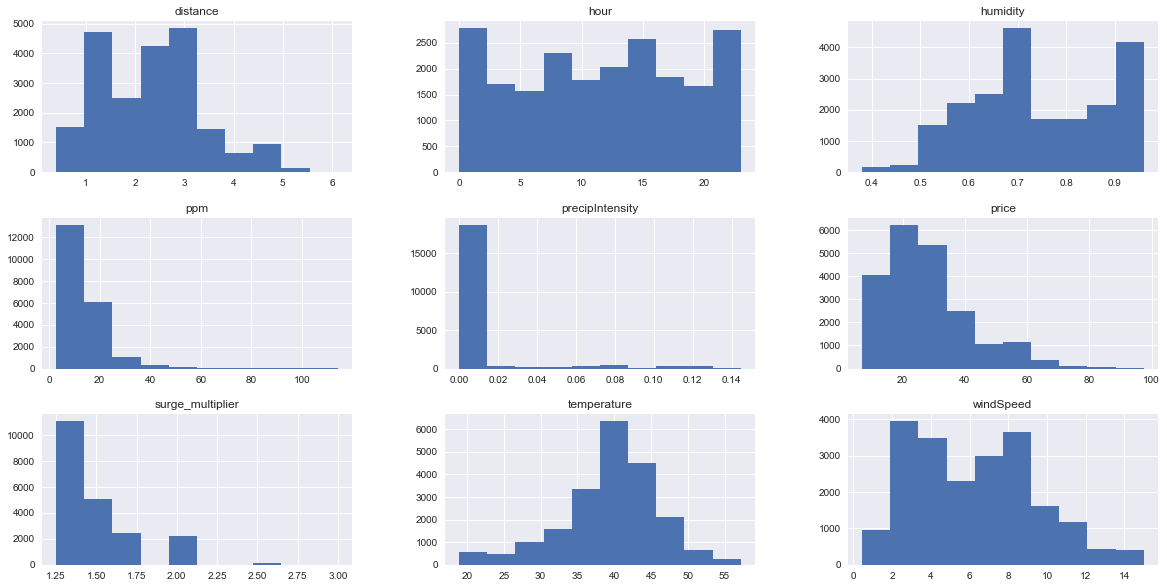

In [71]:
%matplotlib inline
plt.figure(figsize = (25, 15))
df_box.hist()
plt.gcf().set_size_inches(20, 10)
plt.show()

The last step of my data pre-processing was to filer the remaining dataset to it's user-defined sample size (in case a 100% sample was not selected). 

In [72]:
df_sample = df.sample(round(df.shape[0]*sample_size_pct), random_state = 2)

For the sampled dataset (if applicable), I reproduced hisograms on the same variables below to ensure that distributions remained similar.

<Figure size 1800x1080 with 0 Axes>

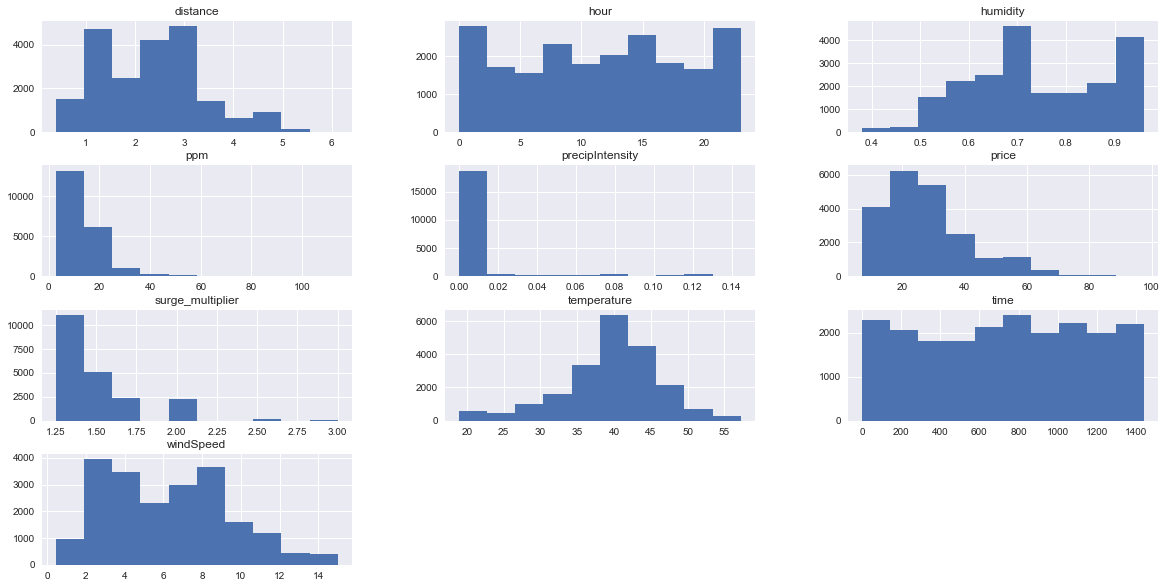

In [73]:

df_box = df_sample.filter(items = columns_to_keep_eda)
df_box = df_box.dropna() #drop NAs

%matplotlib inline
plt.figure(figsize = (25, 15))
df_box.hist()
plt.gcf().set_size_inches(20, 10)
plt.show()

In [74]:
###initial filtering of columns desired for analysis

columns_to_keep_regression = all_variables + ['cab_type', 'ride_type']

df_sample = df_sample.filter(items = columns_to_keep_regression)
df_sample = df_sample.dropna() #drop NAs

#### Build user-functions for comparing Cab Type and Ride Type

Since my secodary goal was compare potential differences between cab types (Uber vs. Lyft) and the ride-share type (Shared/Luxury/Standard), I needed a way to to easily compare these attributes. I created several user-defined functions that set these as user-input parameters. I wrapped these functions into a Python Class to keep my code more organized, and to facilitate easy toggling between Cab and Ride types. 

As a reminder, I would only be able to compare cab_types (Uber vs. Lyft) if I did not filter out non-surge pricing rides.


In [75]:
from sklearn.model_selection import train_test_split
from scipy import stats
import statsmodels.api as sm
# from scipy.stats import f as fisher_f
from sklearn import metrics
from scipy import stats
from sklearn.linear_model import LinearRegression 
import numpy as np


class Data_Filter_Class:    
    
    
    def __init__(self, features, cab_type, ride_type): #build instance
        self.features= features
        self.cab_type = cab_type
        self.ride_type = ride_type     
    def filter_data(self):
        self.features = self.features
        df_filter_features = df_sample.loc[(df_sample['ride_type'].isin(self.ride_type)) & (df_sample['cab_type'].isin(self.cab_type))]
        df_filter = df_filter_features.filter(items = self.features)
        df_filter[target[0]] = df_filter_features[target[0]]

        if any('weekday' in s for s in df_filter.columns):
            df_encode = df_filter['weekday']
            df_filter = pd.concat([df_filter, pd.get_dummies(df_encode, prefix = 'Day', drop_first = True)], axis = 1)
            df_filter.drop(['weekday'], axis=1, inplace = True)
            df_filter = df_filter.reset_index(drop = True)
        else:
            df_filter = df_filter.reset_index(drop = True)                
        return df_filter


#### One-hot encoding

Since days of the week is a categorical variable, I needed to incorporate one-hot encoding so that these could be converted to numeric dummy values. To avoid the dummy variable trap, I made sure to drop one of the derived 'dummy' columns. As shown by the if-else statement in the filter_data function above, this step is only done if 'weekday' is one of the features selected for analysis. This [blog](https://towardsdatascience.com/one-hot-encoding-multicollinearity-and-the-dummy-variable-trap-b5840be3c41a) goes into further detail.

#### Scatterplot Matrix

Next, I wanted to get a feel for the correlation between the features of interest I had selected. So I created a scatterplot matrix that invoked the class object method I had created above (filter_data).

In [76]:
from pandas.plotting import scatter_matrix


def scatter_matrix_plot(variables, cab_type, ride_type):
    filtered_df = Data_Filter_Class(variables, cab_type, ride_type)
    filtered_df = filtered_df.filter_data()
    scatter_matrix(filtered_df, alpha=0.2, figsize=(15,15), diagonal='kde')
 
    return plt.show()

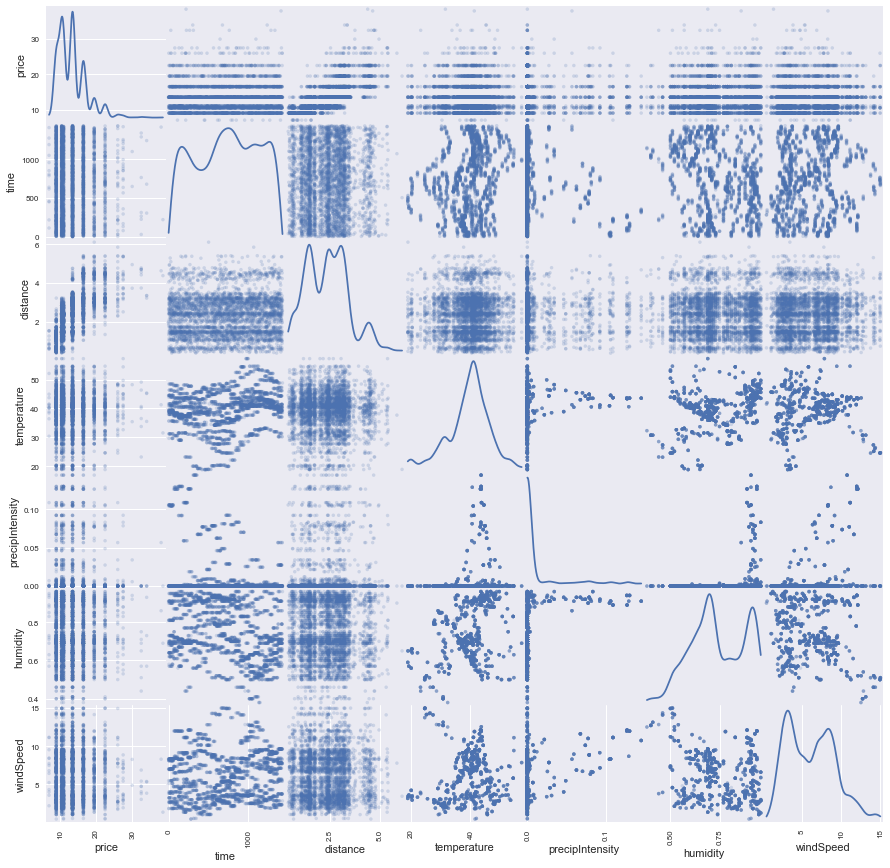

In [77]:
scatter_matrix_plot(columns_to_keep_eda, cab_type_global, ride_type_global)

From this scatterplot, the only variable that seems to have any linear correlation with price is distance. On the diagnol, I plotted density plots to view the distribution of each variable. 

I also printed out the linear correlations for each selected variable with respect to price. As seen, distance by far has the highest correlation. The other variables do not have a linear correlation. 

In [78]:
def correlations(variables, cab_type, ride_type):
    filtered_df = Data_Filter_Class(variables, cab_type, ride_type)
    filtered_df = filtered_df.filter_data()
    print("Correlations with Price")
    corr = filtered_df.corr()
    corr.sort_values(target[0], ascending = False, inplace = True)
    print(corr[target[0]])
    
correlations(all_variables, cab_type_global, ride_type_global)

Correlations with Price
price              1.000000
distance           0.708259
time               0.016034
Day_Saturday       0.011171
Day_Monday         0.009763
precipIntensity    0.003479
humidity           0.001741
temperature        0.001302
Day_Wednesday     -0.005717
windSpeed         -0.007876
Day_Tuesday       -0.009083
Day_Sunday        -0.013671
Day_Thursday      -0.027094
Name: price, dtype: float64


## Simple and Multivariate Linear Regression

The first machine learning model I wanted to test was linear regression. Based on the correlation matrix above, I could already see that there was a linear correlation between distance and price. I wanted to test how strong of a predictor distance is, and whether there are any other variables that have a significant impact on price.



I expanded on the class function I had built above, (used to filter my dataset), and added functions that did the following:

- Establish a training/testing dataset: I chose to use the "Hold-Out" method, and split the training/test data by 80/20%, repsectively. 
    - While cross-fold validation is frequently used in model evaluation, it is also more computationally expensive. Since my sample size was fairly large (>20K records), I felt the Hold-Out method was sufficient.
- Create a linear model: I used the sklearn library for this, and fit a model on the training predictor variables and target value of price. This function is applicable to simple or multivariate linear regression model, depending which variables are selected.
- Predict values: Based on the model that was fitted, I created an array of predicted values
- Calculate linear equation: Return the linear equation for the slope of the linear model, which includes the coefficient weights and intercept value.
- Calculate performance metrics for validation data: I've included the calculation of numerous regression metrics to evaluate the performance of the model on the validation data. These metrics include the unadjusted and adjusted r-squared coefficient, mean-absolute error (MAE), mean-squared error (MSE), and Root-mean-squared error (RMSE). 
- Calculate performance metrics for training data: I calculated the same metrics described above on the training data. After the model was fitted to the training data, I calculated prediction accuracy for each data point in the training data. The purpose of this was to guague the bias and variance of my model (e.g. whether it was over-fitted to my training dataset).  


In [79]:

from sklearn.model_selection import train_test_split
from scipy import stats
import statsmodels.api as sm
from scipy.stats import f as fisher_f
from sklearn import metrics
from scipy import stats
from sklearn.linear_model import LinearRegression 
import numpy as np


#initialize values for each class instance
class MyLinearRegression:    
    def __init__(self, features, cab_type, ride_type): #build instance
        self.features= features
        self.cab_type = cab_type
        self.ride_type = ride_type     
##build function for filtering data based with input parameters of data features, cab_type, and ride_type 
    def filter_data(self):
        self.features = self.features
        df_filter_features = df_sample.loc[(df_sample['ride_type'].isin(self.ride_type)) & (df_sample['cab_type'].isin(self.cab_type))]
        df_filter = df_filter_features.filter(items = self.features)
        df_filter[target[0]] = df_filter_features[target[0]]
        if any('weekday' in s for s in df_filter.columns):
            df_encode = df_filter['weekday']
            df_filter = pd.concat([df_filter, pd.get_dummies(df_encode, prefix = 'Day', drop_first = True)], axis = 1)
            df_filter.drop(['weekday'], axis=1, inplace = True)
            df_filter = df_filter.reset_index(drop = True)
        else:
            df_filter = df_filter.reset_index(drop = True)                
        return df_filter

    def split_data(self):
        df_filter = self.filter_data()
        X = df_filter.loc[:, df_filter.columns != target[0]]
        Y = df_filter[target[0]]
        X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size = 0.2, random_state = 0)
        return X_train, X_test, y_train, y_test

    def create_model(self):
        X_train, X_test, y_train, y_test = self.split_data()
        model_cab = LinearRegression()
        model_cab.fit(X_train, y_train)
        return model_cab

    def predict_model(self):
        X_train, X_test, y_train, y_test = self.split_data()
        return_model = self.create_model()
        fit_model = return_model.fit(X_train, y_train)
        predict = return_model.predict(X_test)
        return predict

    def linear_formula(self):
        X_train, X_test, y_train, y_test = self.split_data()
        return_model = self.create_model()
        fit_model = return_model.fit(X_train, y_train)
        slope = fit_model.coef_[0]
        intercept = fit_model.intercept_
        print(f"The linear regression line for " + "is y = " + str(round(slope,2))+ "x + " + str(round(intercept,2))) 

    def metric_r2(self):
        X_train, X_test, y_train, y_test = self.split_data()
        return_model = self.create_model()
        fit_model = return_model.fit(X_train, y_train)
        r2_score = return_model.score(X_test, y_test)
        return round(r2_score,3)

    def metric_MAE(self):
        predicted = self.predict_model()        
        model_cab = self.create_model()
        X_train, X_test, y_train, y_test = self.split_data()
        model_cab.fit(X_train, y_train)
        MAE= metrics.mean_absolute_error(predicted, y_test)
        return round(MAE,3)

    def metric_MSE(self):
        predicted = self.predict_model()        
        model_cab = self.create_model()
        X_train, X_test, y_train, y_test = self.split_data()
        model_cab.fit(X_train, y_train)
        MAE= metrics.mean_squared_error(predicted, y_test)
        return round(MAE,3)

    def metric_RMSE(self):
        predicted = self.predict_model()        
        model_cab = self.create_model()
        X_train, X_test, y_train, y_test = self.split_data()
        model_cab.fit(X_train, y_train)
        MAE= np.sqrt(metrics.mean_squared_error(predicted, y_test))
        return round(MAE,3)
    
    def metric_adj_r2(self):
        X_train, X_test, y_train, y_test = self.split_data()
        return_model = self.create_model()
        fit_model = return_model.fit(X_train, y_train)
        r2_score = return_model.score(X_test, y_test) 
        adj_r2 = 1 - (1-r2_score)*(len(y_test)-1)/(len(y_test)-X_test.shape[1]-1)
        return round(adj_r2,3)

    
    def predict_model_train(self):
        X_train, X_test, y_train, y_test = self.split_data()
        return_model = self.create_model()
        fit_model = return_model.fit(X_train, y_train)
        predict = return_model.predict(X_train)
        return predict
    
    def metric_r2_train(self):
        X_train, X_test, y_train, y_test = self.split_data()
        return_model = self.create_model()
        fit_model = return_model.fit(X_train, y_train)
        r2_score = return_model.score(X_train, y_train)
        return round(r2_score,3)

    def metric_MAE_train(self):
        predicted = self.predict_model_train()        
        model_cab = self.create_model()
        X_train, X_test, y_train, y_test = self.split_data()
        model_cab.fit(X_train, y_train)
        MAE= metrics.mean_absolute_error(predicted, y_train)
        return round(MAE,3)

    def metric_MSE_train(self):
        predicted = self.predict_model_train()        
        model_cab = self.create_model()
        X_train, X_test, y_train, y_test = self.split_data()
        model_cab.fit(X_train, y_train)
        MAE= metrics.mean_squared_error(predicted, y_train)
        return round(MAE,3)

    def metric_RMSE_train(self):
        predicted = self.predict_model_train()        
        model_cab = self.create_model()
        X_train, X_test, y_train, y_test = self.split_data()
        model_cab.fit(X_train, y_train)
        MAE= np.sqrt(metrics.mean_squared_error(predicted, y_train))
        return round(MAE,3)
    
    def metric_adj_r2_train(self):
        X_train, X_test, y_train, y_test = self.split_data()
        return_model = self.create_model()
        fit_model = return_model.fit(X_train, y_train)
        r2_score = return_model.score(X_train, y_train) 
        adj_r2 = 1 - (1-r2_score)*(len(y_train)-1)/(len(y_train)-X_train.shape[1]-1)
        return round(adj_r2,3)
    
    

#### Simple Linear Regression

The first linear regression model I wanted to explore was simple linear regression. Recall that distance was defined at the beginning as my global parameter for all subsequent simple regression.

In [80]:
def plot_linear(cab_type, ride_type):
    variables = single_var
    lin_reg_simple = MyLinearRegression(variables,cab_type,ride_type)
    X_train, X_test, y_train, y_test = lin_reg_simple.split_data()

    ###convert split datasets into numpy arrays
    X_train = X_train.iloc[:, 0] ##convert to series
    X_train = np.array(X_train)
    X_train = X_train[:,np.newaxis]
    y_train = np.array(y_train)

    X_test = X_test.iloc[:, 0] ##convert to series
    X_test = np.array(X_test)
    y_test = np.array(y_test)

    model = LinearRegression()
    model.fit(X_train, y_train)
    # predict y from the data
    x_new = X_test
    y_new = model.predict(X_test[:, np.newaxis])
    y_new
    # plot the results
    plt.figure(figsize=(10, 7))
    ax = plt.axes()
    ax.scatter(x_new, y_test)
    ax.plot(x_new, y_new, c = 'red')

    ax.set_xlabel(single_var[0])
    ax.set_ylabel(target[0])
    ax.set_title('Simple Linear Regression')

    plt.show()
    print('The Mean Absolute Error is ' + str(lin_reg_simple.metric_MAE()))
    return lin_reg_simple.linear_formula()

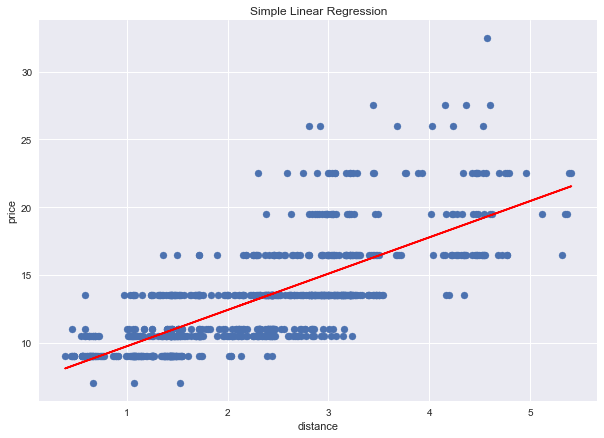

The Mean Absolute Error is 1.977
The linear regression line for is y = 2.68x + 7.06


In [81]:
plot_linear(cab_type_global, ride_type_global)

##### Plotting Error Residuals

The output above proves that there is clearly a linear correlation with distance and price. However, there is noticeable error in predictions on my test dataset. The Mean Absolute metric shows that predicted price is off by an average of nearly $2. I plotted the error residuals to look further into this.

In [82]:
# Plot residuals
def plot_residual(cab_type, ride_type):
    
    fig, (ax1, ax2) = plt.subplots (1,2, figsize=(20,6))    
    variables = single_var
    lin_reg_simple = MyLinearRegression(variables,cab_type,ride_type)
    X_train, X_test, y_train, y_test = lin_reg_simple.split_data()

    X_train = X_train.iloc[:, 0] ##convert to series
    X_train = np.array(X_train)
    X_train = X_train[:,np.newaxis]
    y_train = np.array(y_train)

    X_test = X_test.iloc[:, 0] ##convert to series
    X_test = np.array(X_test)
    y_test = np.array(y_test)

    model = LinearRegression()
    model.fit(X_train, y_train)
    # predict y from the data
    x_new = X_test
    y_new = model.predict(X_test[:, np.newaxis])
    y_new
    
    ax1.scatter(y_new, y_new - y_test, c = "blue", marker = "s", label = "Training data", alpha = 0.1)
    ax1.set_title("Residual of Simple Linear Regression Errors")
    ax1.set_xlabel("Predicted values")
    ax1.set_ylabel("Residuals")
    ax1.legend(loc = "upper left")
    ax1.hlines(y = 0, xmin = 0, xmax = 20, color = "red")

    ax2.hist(y_new - y_test)
    ax2.set_title("Distribution of Residuals")
    ax2.set_xlabel("Residual")
    ax2.set_ylabel("Count")

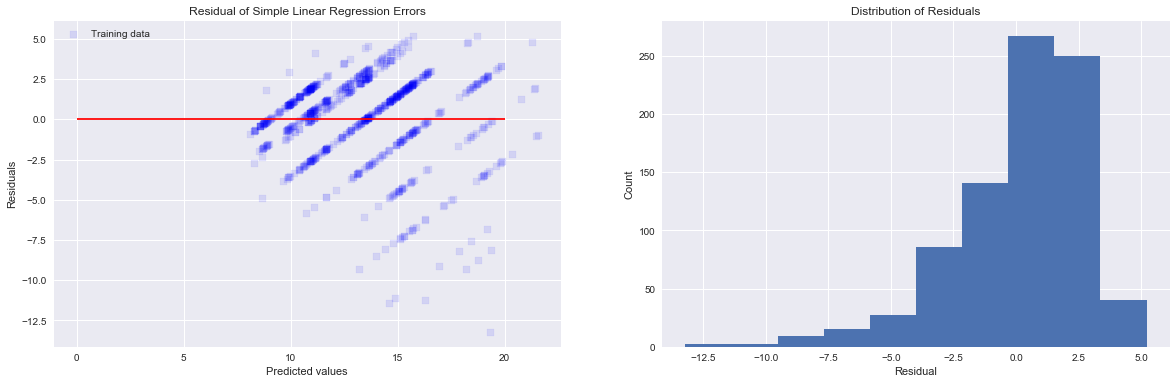

In [83]:
plot_residual(cab_type_global, ride_type_global)

It seems like the majority of predictions overestimate the actual price - particularly at lower price points. As ride prices get higher, the predictions tend to underestimate the price.

#### Multivariate Linear Regression Model

Since I suspect that several features will have an impact on Uber/Lyft prices, I wanted to test the performance of a multivariate regression model. When doing so, I wanted to ensure that the variables included in this model have a statistically significant impact on price. Therefore, I used the "backwards elimination" method to determine relevant predictors. This [article](https://www.jmp.com/en_us/statistics-knowledge-portal/what-is-multiple-regression/variable-selection.html) explains it in further detail.

This method looks at the p-value of all variables input into a multivariate regression. If any variables have a p-value that is > than the signifance level (alpha) you assign (0.05 by default), then the variable with the highest p-value is removed from the regression model and the updated model is re-run. This process repeats until there are no variables left with a p-value > than assigned alpha.


In [84]:

def linear_params_test(variables, cab_type, ride_type, sigvalue):
    returned_df = MyLinearRegression(variables, cab_type,ride_type)
    df_filter = returned_df.filter_data()    
    X = df_filter.loc[:, df_filter.columns != target[0]]
    Y = df_filter[target[0]]
    X = sm.add_constant(X) ##statsmodels library does not add a constant by default
    X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size = 0.2, random_state = 0)
    lrmodel = sm.OLS(y_train, X_train).fit()
    pVals = lrmodel.pvalues
    pVals = pVals.to_frame().reset_index(drop = False)
    pVals.columns= ['index', 'pvalue']
    while max(pVals['pvalue'])>sigvalue:
        for p in range(0, len(pVals['pvalue'])): 
            p_value = pVals['pvalue'][p]
            i_max = pVals['pvalue'].values.argmax()
            column_drop = pVals['index'][i_max]
        X_train.drop([column_drop], axis = 1, inplace = True)
        X_test.drop([column_drop], axis = 1, inplace = True)
        lrmodel = sm.OLS(y_train,X_train).fit()
        pVals= lrmodel.pvalues
        pVals = pVals.to_frame().reset_index(drop = False)
        pVals.columns= ['index', 'pvalue']
    
    lrmodel = sm.OLS(y_train, X_train).fit()

    return lrmodel


def linear_params_summary(variables, cab_type, ride_type, sigvalue):
    lrmodel = linear_params_test(variables, cab_type, ride_type, sigvalue)
    summary = lrmodel.summary()
    return summary



##### Interactive Widget: Backward Elimination of Irreleveant Variables

In the interactive widget below, users can view summary analysis (using the statsmodel library) of their specified multivariate regression analysis. This widget uses backwards-elimination to iterate through multivariate regression models until it ends up with one that only includes variables with a statistically significant impact on predicting price. In other words, the remaining features in the regression model must have a p-value that is > than the user-specified alpha (0.05 by default). Users can define the significance level (alpha) below, and also have the ability to to filter their model by cab type(s) and ride type(s).


In [85]:
#jupyter nbextension enable --py widgetsnbextension
from __future__ import print_function
from ipywidgets import interact, interactive, fixed, interact_manual
import ipywidgets as widgets
from IPython.display import display
output = widgets.Output()
other_output = widgets.Output()



cab_type =widgets.SelectMultiple(
            options=['Uber', 'Lyft'],
#             value=['Lyft'], #optional default value
            description='Cab Type',
            disabled=False
)

ride_type =widgets.SelectMultiple(
            options=['Shared', 'Luxury', 'Standard'],
#             value=['Standard'], #optional default value
            description='Ride Type',
            disabled=False
)

sigvalue =widgets.FloatSlider(
            min = 0,
            max = 1,
            step = .05,
            description = 'Alpha:',
#             value = 0.05
)

def linear_backwards_elim(cab_type, ride_type, sigvalue):
    output.clear_output() 
    other_output.clear_output()
    cab_type = list(cab_type)
    ride_type = list(ride_type)
    with output:
        display(cab_type, ride_type, sigvalue)
    with other_output:
        variables = all_variables
        lrmodel = linear_params_test(variables, cab_type, ride_type, sigvalue)
        summary = lrmodel.summary()
        display(summary)
        


def cab_type_event(change):
    linear_backwards_elim(change.new, ride_type.value, sigvalue.value)
        
def ride_type_event(change):
    linear_backwards_elim(cab_type.value, change.new, sigvalue.value)
    
def sig_value_event(change):
    linear_backwards_elim(cab_type.value, ride_type.value, change.new)
        
        
cab_type.observe(cab_type_event, names = 'value')
ride_type.observe(ride_type_event, names = 'value')
sigvalue.observe(sig_value_event, names = 'value')


# display(variables)
display(cab_type)
display(ride_type)
display(sigvalue)
display(output)
display(other_output)


SelectMultiple(description='Cab Type', options=('Uber', 'Lyft'), value=())

SelectMultiple(description='Ride Type', options=('Shared', 'Luxury', 'Standard'), value=())

FloatSlider(value=0.0, description='Alpha:', max=1.0, step=0.05)

Output()

Output()

In case the widget above is not viewable or doesn't work, I've pasted images below of what the widget looks like at p-values of 0.05 and 0.25.

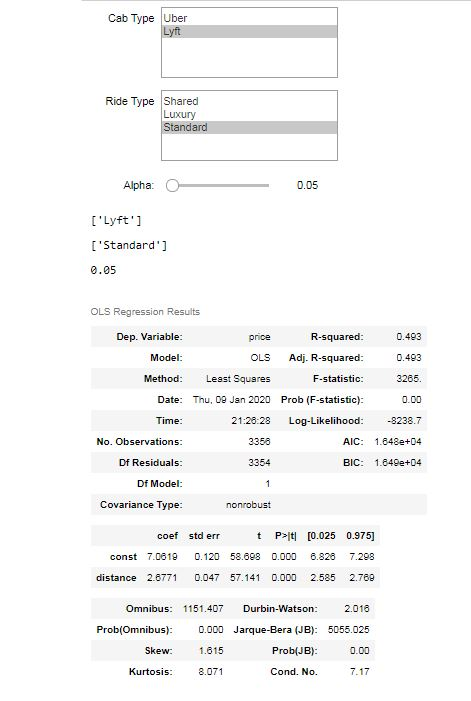

In [86]:
from IPython.display import Image
PATH = "C:\\Users\\oshapira\\Downloads\\"
Image(filename = PATH + "widget_5.jpg", width=500, height=500)

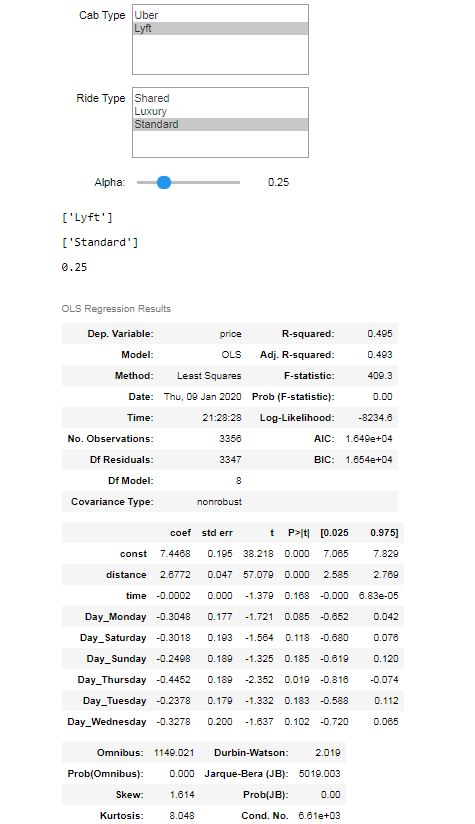

In [87]:
from IPython.display import Image
PATH = "C:\\Users\\oshapira\\Downloads\\"
Image(filename = PATH + "widget_25.jpg", width=500, height=500)

You may notice that 'distance' is by far the most statistically significant predictor of price. Other variables are excluded from the regression model unless a very large alpha value is set for the significance level. At alpha = 0.25, several variables pertaining to day of week become statistically significant.

#### Higher-degree polynomial regerssions

Since it seemed like variables besides distance had minimal impact, I wanted to see if a simple quadratic or polynomial regression model would perform well. The Class object below function in a simlar manner to the one built for linear regression.

In [88]:

############different degrees with regression

import statsmodels.formula.api as smf

class MyPolyRegression:    
    def __init__(self, cab_type, ride_type, degrees): #build instance
        self.cab_type = cab_type
        self.ride_type = ride_type
        self.degrees = degrees


    def filter_data(self):
        features = [single_var[0]]    
        df_filter_features = df_sample.loc[(df_sample['ride_type'].isin(self.ride_type)) & (df_sample['cab_type'].isin(self.cab_type))]
        df_filter = df_filter_features.filter(items = features)
        df_filter[target[0]] = df_filter_features[target[0]]
        if any('weekday' in s for s in df_filter.columns):
            df_encode = df_filter['weekday']
            df_filter = pd.concat([df_filter, pd.get_dummies(df_encode, prefix = 'Day', drop_first = True)], axis = 1)
            df_filter.drop(['weekday'], axis=1, inplace = True)
            df_filter = df_filter.reset_index(drop = True)
        else:
            df_filter = df_filter.reset_index(drop = True)                
        return df_filter
    
    def split_data(self):
        df_filter = self.filter_data()
        X = df_filter.loc[:, df_filter.columns != target[0]]
        Y = df_filter[target[0]]
        X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size = 0.2, random_state = 0)
        X_train = X_train[single_var[0]].values
        X_test = X_test[single_var[0]].values
        y_train = np.asarray(y_train)
        y_test = np.asarray(y_test)    
        return X_train, X_test, y_train, y_test


    def create_model(self):
        degrees = self.degrees
        X_train, X_test, y_train, y_test = self.split_data()
        weights = np.polyfit(X_train, y_train, degrees)
        model = np.poly1d(weights)
        return model

    def predict_model(self):
        X_train, X_test, y_train, y_test = self.split_data()
        return_model = self.create_model()
        predict = return_model(X_test)
        return predict
    
    def metric_r2(self):
        X_train, X_test, y_train, y_test = self.split_data()
        predicted = self.predict_model() 
        r2 = round(metrics.r2_score(y_test, predicted),3)
        return r2

    def metric_MAE(self):
        X_train, X_test, y_train, y_test = self.split_data()
        predicted = self.predict_model() 
        MAE= metrics.mean_absolute_error(y_test, predicted)
        return round(MAE,3)
    
    def metric_MSE(self):
        X_train, X_test, y_train, y_test = self.split_data()
        predicted = self.predict_model() 
        MSE= metrics.mean_squared_error(y_test, predicted)
        return round(MSE,3)
    
    def metric_RMSE(self):
        X_train, X_test, y_train, y_test = self.split_data()
        predicted = self.predict_model() 
        RMSE= np.sqrt(metrics.mean_squared_error(y_test, predicted))
        return round(RMSE,3)
    
    def metric_adj_r2(self):
        X_train, X_test, y_train, y_test = self.split_data()
        predicted = self.predict_model() 
        r2_score = round(metrics.r2_score(y_test, predicted),3)
        adj_r2 = 1 - (1-r2_score)*(len(y_test)-1)/(len(y_test)-1-1)
        return round(adj_r2,3)


    def predict_model_train(self):
        X_train, X_test, y_train, y_test = self.split_data()
        return_model = self.create_model()
        predict = return_model(X_train)
        return predict

    def metric_r2_train(self):
        X_train, X_test, y_train, y_test = self.split_data()
        predicted = self.predict_model_train() 
        r2 = round(metrics.r2_score(y_train, predicted),3)
        return r2

    def metric_MAE_train(self):
        X_train, X_test, y_train, y_test = self.split_data()
        predicted = self.predict_model_train() 
        MAE= metrics.mean_absolute_error(y_train, predicted)
        return round(MAE,3)
    
    def metric_MSE_train(self):
        X_train, X_test, y_train, y_test = self.split_data()
        predicted = self.predict_model_train() 
        MSE= metrics.mean_squared_error(y_train, predicted)
        return round(MSE,3)
    
    def metric_RMSE_train(self):
        X_train, X_test, y_train, y_test = self.split_data()
        predicted = self.predict_model_train() 
        RMSE= np.sqrt(metrics.mean_squared_error(y_train, predicted))
        return round(RMSE,3)

    def metric_adj_r2_train(self):
        X_train, X_test, y_train, y_test = self.split_data()
        predicted = self.predict_model_train() 
        r2_score = round(metrics.r2_score(y_train, predicted),3)
        adj_r2 = 1 - (1-r2_score)*(len(y_train)-1)/(len(y_train)-1-1)
        return round(adj_r2,3)
    

#### Chow Test: Compare Prices on Weekdays vs. Weekends

Given that the multivariate regression model showed slight significance to days of the week as predictors, I was curious to explore this more. More specifically, I wanted to see whether it would be preferred to use one simple regerssion model fit to all days of the week, or if it would be more effective to split into two regression models - one fitted for weekdays, and one fitted for weekends.

I used the Chow test method to determine this. This method compares the sum of squared errors (SSE) for a model that looks at all days a week, and compares it to the SSE for regression on weekends-only + the SSE for regression fit to weekends-only. An F-test is then performed to indicate whether the SSE between the "all days" model and the separated weekday/weekend models is statistically significant.

In [89]:

class MyChowModel:    
    def __init__(self, days, degrees): #build instance
        self.degrees = degrees
        self.days = days

    def filter_data(self):
        df_filter_features = df_sample.loc[(df_sample['weekday'].isin(self.days))]
        df_filter = df_filter_features.filter(items = all_variables)
        df_filter = df_filter.reset_index(drop = True)                
        return df_filter
    
    def split_data(self):
        df_filter = self.filter_data()
        X = df_filter.loc[:, df_filter.columns != target[0]]
        Y = df_filter[target[0]]
        X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size = 0.2, random_state = 0)
        X_train = X_train[single_var[0]].values
        X_test = X_test[single_var[0]].values
        y_train = np.asarray(y_train)
        y_test = np.asarray(y_test)    
        return X_train, X_test, y_train, y_test
#         return df_filter

    def create_model(self):
        degrees = self.degrees
        X_train, X_test, y_train, y_test = self.split_data()
        weights = np.polyfit(X_train, y_train, degrees)
        model = np.poly1d(weights)
        return model

    def predict_model(self):
        X_train, X_test, y_train, y_test = self.split_data()
        return_model = self.create_model()
        predict = return_model(X_test)
        return predict

In [90]:


###########chow test

weekend = ['Saturday', 'Sunday']
weekdays = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday']
all_days = weekend + weekdays

from scipy.stats import f as fisher_f
def chow_test(alpha_val, degrees):
    

    ##get dataset for both weekdays and weekends 
    all_lin_reg_simple = MyChowModel(all_days, degrees)
    y_test_all = all_lin_reg_simple.predict_model()
    predict_all = np.asarray(all_lin_reg_simple.split_data()[3])
    
    ##Predictions for Weekdays Only
    weekdays_lin_reg_simple = MyChowModel(weekdays,degrees)
    y_test_weekdays = weekdays_lin_reg_simple.predict_model()
    predict_weekdays = np.asarray(weekdays_lin_reg_simple.split_data()[3])
    ##Predictions for Weekends Only
    weekend_lin_reg_simple = MyChowModel(weekend, degrees)
    y_test_weekend = weekend_lin_reg_simple.predict_model()
    predict_weekend = np.asarray(weekend_lin_reg_simple.split_data()[3])
    
    ##Add up Sum of Squared Errors
    SSE_all = sum((np.asarray(y_test_all - predict_all))*(np.asarray(y_test_all - predict_all)))
    SSE_weekdays = sum((np.asarray(y_test_weekdays - predict_weekdays))*(np.asarray(y_test_weekdays - predict_weekdays)))
    SSE_weekend = sum((np.asarray(y_test_weekend - predict_weekend))*(np.asarray(y_test_weekend - predict_weekend)))

    N = len(y_test_all)
    deg_freedom_all = len(y_test_all) - 1 
    deg_freedom_1_lyft = len(y_test_weekdays) - 1
    deg_freedom_2_uber = len(y_test_weekend) - 1
    
    k = 2 # one dimensional regression - slope and intercept
    numerator = (SSE_all - (SSE_weekdays + SSE_weekend))/k
    denominator = (SSE_weekdays + SSE_weekend)/(N - 2*k) #both regression have 2 degrees of freedom
    
    f_statistics = numerator/denominator #calculate f-statistic significant value for each months' regressions
    
    alpha = alpha_val
    p_value = fisher_f.cdf(f_statistics, 2, N-2*2) ##calculate critical value for degrees 2 and 2
    
    if p_value > alpha:
        print("The Chow test shows that there is a statistically significant difference between the regression lines for weekdays and weekends" +
               "\n" + "The sum of SSE for weekday-only and weekend-only regression is  " + str(round(SSE_weekdays + SSE_weekend,2)) +
              " (" + str(round(SSE_weekdays,2)) + " + " + str(round(SSE_weekend,2)) + ")" 
               "\n" + "The SSE for Both is " + str(round(SSE_all,2)))

    else:
        print("The Chow test shows that there is NOT a statistically significant difference between the regression lines for weekdays and weekends" +
               "\n" + "The sum of SSE for weekday-only and weekend-only regression is  " + str(round(SSE_weekdays + SSE_weekend,2)) +
              " (" + str(round(SSE_weekdays,2)) + " + " + str(round(SSE_weekend,2)) + ")" 
               "\n" + "The SSE for Both is " + str(round(SSE_all,2)))



In [91]:
from plotly.offline import init_notebook_mode, iplot
import plotly.express as px
from plotly.offline import plot
import plotly.graph_objs as go

def lin_reg_cab_df(days, degree):
    lin_reg_simple = MyChowModel(days, degree)
    X_train, X_test, y_train, y_test = lin_reg_simple.split_data()
    model = lin_reg_simple.create_model()
    y_pred = model(X_test)

    X_test = pd.DataFrame(X_test)
    y_test = pd.DataFrame(y_test)
    y_pred = pd.DataFrame(y_pred)

    cab_df = pd.concat([X_test, y_test, y_pred], axis = 1)
    cab_df.columns = [single_var[0], 'actual_price', 'predicted_price']
    cab_df = cab_df.sort_values(by=[single_var[0]])
    return cab_df


def plot_lin_reg(degree):
    weekdays_df = lin_reg_cab_df(weekdays, degree)
    weekend_df = lin_reg_cab_df(weekend, degree)

    fig = go.Figure()
    fig.update_layout(
    title="Chow Test for " + str(degree) + "-Degree Linear Regression Comparison for Weekdays vs. Weekends",
    xaxis_title=single_var[0],
    yaxis_title=target[0],

)
    
    fig.add_trace(go.Scatter(
            x = weekdays_df[single_var[0]], 
            y  = weekdays_df['actual_price'], 
            mode = 'markers',
            marker = dict(opacity = 0.5),
            name = 'Weekdays Actual Prices'
            ))
    fig.add_trace(go.Scatter(
            x = weekend_df[single_var[0]], 
            y  = weekend_df['actual_price'], 
            mode = 'markers',
            marker = dict(opacity = 0.5),
            name = 'Weekend Actual Prices',
            ))
    
    fig.add_trace(go.Scatter(
            x = weekdays_df[single_var[0]], 
            y  = weekdays_df['predicted_price'], 
            mode = 'lines',
            line=dict(width=5),
            name = 'Weekdays Regression Line'
            ))
    
    fig.add_trace(go.Scatter(
            x = weekend_df[single_var[0]], 
            y  = weekend_df['predicted_price'], 
            mode = 'lines',
            line=dict(width=5),
            name = 'Weekend Regression Line'
            ))
    
    
    fig.show()



The plot below shows a polynomial (3-degree) line fitted to regression models for weekdays and weekend days. It can visually be seen that these regression lines are very similar. And the Chow test (with alpha = 0.05) validates that the difference between these regression lines is not statistically significant.

In [92]:
plot_lin_reg(3)
chow_test(.05,3)

The Chow test shows that there is NOT a statistically significant difference between the regression lines for weekdays and weekends
The sum of SSE for weekday-only and weekend-only regression is  670929.82 (485866.36 + 185063.46)
The SSE for Both is 669517.94


#### Summarize Performance Metrics of Model

In [48]:


def performance_metrics(cab_type, ride_type):
    #metrics on testing validation set
    reg_simple_list = ['Simple Linear Regression']
    reg_simple = MyLinearRegression([target[0], single_var[0]], cab_type,ride_type)
    reg_simple_list.append(reg_simple.metric_r2())
    reg_simple_list.append(reg_simple.metric_MAE())
    reg_simple_list.append(reg_simple.metric_MSE())
    reg_simple_list.append(reg_simple.metric_RMSE())
    reg_simple_list.append(reg_simple.metric_adj_r2())
    ##metrics on training dataset
    reg_simple_list.append(reg_simple.metric_r2_train())
    reg_simple_list.append(reg_simple.metric_MAE_train())
    reg_simple_list.append(reg_simple.metric_MSE_train())
    reg_simple_list.append(reg_simple.metric_RMSE_train())
    reg_simple_list.append(reg_simple.metric_adj_r2_train())
    simple_df = pd.DataFrame(np.asarray(reg_simple_list).reshape(1,11), 
                                                columns = ['Regression Type','r2', 'MAE', 'MSE', 'RMSE', 
                                                'Adj_R2','r2_train', 'MAE_train', 'MSE_train', 
                                                'RMSE_train', 'Adj_R2_train'])
    
    reg_multi_list = ['Multiple Linear Regression']
    reg_multi = MyLinearRegression(all_variables, cab_type,ride_type)
    reg_multi_list.append(reg_multi.metric_r2())
    reg_multi_list.append(reg_multi.metric_MAE())
    reg_multi_list.append(reg_multi.metric_MSE())
    reg_multi_list.append(reg_multi.metric_RMSE())
    reg_multi_list.append(reg_multi.metric_adj_r2())
    
    reg_multi_list.append(reg_multi.metric_r2_train())
    reg_multi_list.append(reg_multi.metric_MAE_train())
    reg_multi_list.append(reg_multi.metric_MSE_train())
    reg_multi_list.append(reg_multi.metric_RMSE_train())
    reg_multi_list.append(reg_multi.metric_adj_r2_train())
    multi_df = pd.DataFrame(np.asarray(reg_multi_list).reshape(1,11),
                                                columns = ['Regression Type','r2', 'MAE', 'MSE', 'RMSE', 
                                                'Adj_R2','r2_train', 'MAE_train', 'MSE_train', 
                                                'RMSE_train', 'Adj_R2_train'])
    reg_simple_list = ['Quadratic Regression']    
    reg_simple = MyPolyRegression(cab_type,ride_type, 2)
    reg_simple_list.append(reg_simple.metric_r2())
    reg_simple_list.append(reg_simple.metric_MAE())
    reg_simple_list.append(reg_simple.metric_MSE())
    reg_simple_list.append(reg_simple.metric_RMSE())
    reg_simple_list.append(reg_simple.metric_adj_r2())

    reg_simple_list.append(reg_simple.metric_r2_train())
    reg_simple_list.append(reg_simple.metric_MAE_train())
    reg_simple_list.append(reg_simple.metric_MSE_train())
    reg_simple_list.append(reg_simple.metric_RMSE_train())
    reg_simple_list.append(reg_simple.metric_adj_r2_train())
    quad_df = pd.DataFrame(np.asarray(reg_simple_list).reshape(1,11), 
                                                columns = ['Regression Type','r2', 'MAE', 'MSE', 'RMSE', 
                                                'Adj_R2','r2_train', 'MAE_train', 'MSE_train', 
                                                'RMSE_train', 'Adj_R2_train'])
    
    reg_simple_list = ['Polynomial Regression']    
    reg_simple = MyPolyRegression(cab_type,ride_type, 3)
    reg_simple_list.append(reg_simple.metric_r2())
    reg_simple_list.append(reg_simple.metric_MAE())
    reg_simple_list.append(reg_simple.metric_MSE())
    reg_simple_list.append(reg_simple.metric_RMSE())
    reg_simple_list.append(reg_simple.metric_adj_r2())

    reg_simple_list.append(reg_simple.metric_r2_train())
    reg_simple_list.append(reg_simple.metric_MAE_train())
    reg_simple_list.append(reg_simple.metric_MSE_train())
    reg_simple_list.append(reg_simple.metric_RMSE_train())
    reg_simple_list.append(reg_simple.metric_adj_r2_train())
    poly_df = pd.DataFrame(np.asarray(reg_simple_list).reshape(1,11), 
                                                columns = ['Regression Type','r2', 'MAE', 'MSE', 'RMSE', 
                                                'Adj_R2','r2_train', 'MAE_train', 'MSE_train', 
                                                'RMSE_train', 'Adj_R2_train'])

    all_dfs = [simple_df, multi_df, quad_df, poly_df]
    all_results_df = pd.concat(all_dfs).reset_index(drop = True)
    return all_results_df




In the data frame below, I summarized the performance of the simple linear, multivariate, and higher-degree polynomial regression models using several common metrics - listed below. This [article](https://towardsdatascience.com/how-to-select-the-right-evaluation-metric-for-machine-learning-models-part-1-regrression-metrics-3606e25beae0) nicely summarizes each of the metrics and their associated advantages and disadvantages. The first 5 columns represent models that were fitted against the training dataset, and tested against the test data we had partitioned earlier on. 

Performance on validation dataset:
- r2: The r-squared score, also known as the coefficient of determination, explains the variability of the model attributed to its variables. It is the ratio between how good the model is vs. how good the naive mean model is (always predicting mean values of target variable).
- Adj_r2: The Adjusted r-squared considers the marginal improvement added by additional variables to the model. It is always equal to or less than the r-squared value. 
- MSE: Mean Squared Error Measures the average squared error of each prediction. It strongly penalizes outliers
- RMSE: Root Mean Squared Error is the square-root of MSE, and is on the same unit-scale as the target variable.
- MAE: Mean Absolute Error is the average absolute difference between target and predictions. Since all differences are weighed equally, it does not penalize outliers as much.

The latter 5 columns with a suffix of _train were tested on the same training data for which the model was fitted. I did this so I could see how much a model was over or under-fitting the training data.

Since each metric has pros and cons, I felt it was importance to view performance across different metrics for a more wholistic perspective. Ultimately, I focused on hypertuning models to perform well for the r-squared coefficient.


In [49]:
linear_performance_df = performance_metrics(cab_type_global, ride_type_global)
linear_performance_df


Regression Type     r2    MAE    MSE   RMSE Adj_R2 r2_train  \
0    Simple Linear Regression  0.536  1.977  6.771  2.602  0.535    0.493   
1  Multiple Linear Regression  0.532  1.991   6.83  2.613  0.525    0.495   
2        Quadratic Regression   0.54  1.952  6.707   2.59  0.539    0.495   
3       Polynomial Regression  0.545  1.948  6.637  2.576  0.544    0.498   

  MAE_train MSE_train RMSE_train Adj_R2_train  
0     2.045      7.94      2.818        0.493  
1     2.043     7.915      2.813        0.493  
2     2.029     7.913      2.813        0.495  
3     2.022     7.862      2.804        0.498

It seems that the polynomial regression model performed best on the test data, as well as on the training data. It has the lowest MAE/MSE/RMSE, and the highest r2/Adj_r2. 

It also seems that the multivariate regression model performed worse than simple regression using only the 'distance' variable. While the multivariate model fit better against the training data than simple regression, it performed worse on the test data. The adj_r2 score also indicates that adding variables worsened the model, since it is lower than the un-adjusted r2 score.


#### Learning curves of training/validation data

In [50]:
def plot_learning_curves(model, X, y):
    reg_simple_df = MyLinearRegression([target[0],single_var[0]], cab_type_global, ride_type_global)
    X_train, X_val, y_train, y_val = reg_simple_df.split_data()
    train_errors, val_errors = [], []
    for m in range(1, 500):
        model.fit(X_train[:m], y_train[:m])
        y_train_predict = model.predict(X_train[:m])
        y_val_predict = model.predict(X_val)
        train_errors.append(metrics.mean_squared_error(y_train[:m], y_train_predict))
        val_errors.append(metrics.mean_squared_error(y_val, y_val_predict))
    plt.figure(figsize = (15,9))
    plt.plot(np.sqrt(train_errors), "r-+", linewidth=2, label="train")
    plt.plot(np.sqrt(val_errors), "b-", linewidth=3, label="val")
    plt.title('Learning Curve - Simple Regression')
    plt.xlabel('Number of Samples')
    plt.ylabel('RMSE')
    plt.ylim((0,10))
    plt.legend(loc = 'upper right')
    
#     plt.plot(np.sqrt(train_errors), "r-+", linewidth=2, label="train")
#     plt.plot(np.sqrt(val_errors), "b-", linewidth=3, label="val")
    return plt.plot()


To better visualize the over/underfitting of each of these models, the plots below show the learning curve for each model. The y-axis is the RMSE of the model (lower is better) and the x-axis is the number of data point samples tested.



##### Simple Linear Regression

In the simple regression model, you can see that the trainig data performs almost perfectly when there are < 3 data points. Meanwhile, the validation data performs poorly until there are enough data points to smooth out mean error. After roughly ~100 data points, the performance of the training and validation data is almost fully converged. When the sample size increases, performance improves. In this model, the validation model actually performs better than the training data when sample size increases. This can also be seen in the results table where RMSE for the test data < the RMSE_train value.

[]

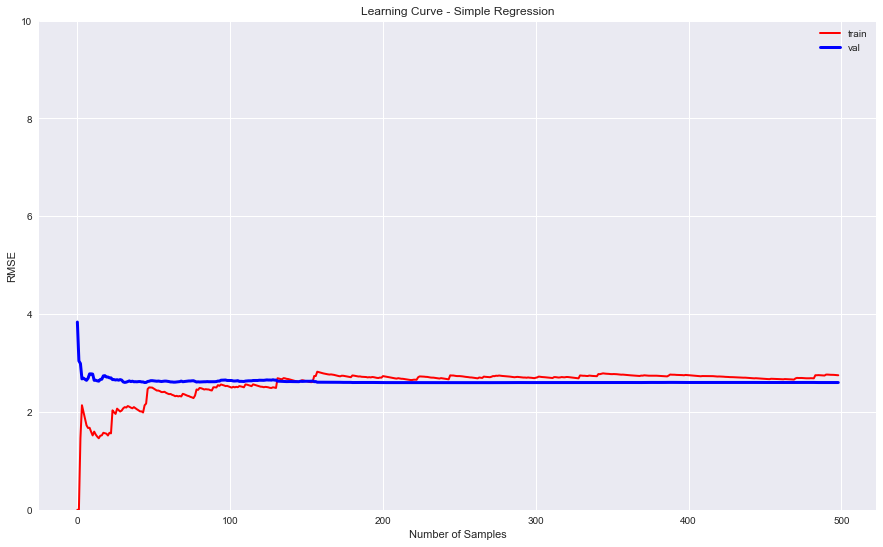

In [51]:
X = df_sample[predictors]
y = df_sample[target[0]]
lin_reg = LinearRegression()
plot_learning_curves(lin_reg, X, y)

##### Multivariate Regression

I created the same plots for the multivariate regression. The RMSE is very high for the fist few datapoints tested

In [52]:
def plot_learning_curves_multi(model, X, y):
    reg_simple_df = MyLinearRegression(all_variables,cab_type_global, ride_type_global)
    X_train, X_val, y_train, y_val = reg_simple_df.split_data()
    train_errors, val_errors = [], []
    for m in range(1, 500):
        model.fit(X_train[:m], y_train[:m])
        y_train_predict = model.predict(X_train[:m])
        y_val_predict = model.predict(X_val)
        train_errors.append(metrics.mean_squared_error(y_train[:m], y_train_predict))
        val_errors.append(metrics.mean_squared_error(y_val, y_val_predict))
    plt.figure(figsize = (15,9))
    plt.plot(np.sqrt(train_errors), "r-+", linewidth=2, label="train")
    plt.plot(np.sqrt(val_errors), "b-", linewidth=3, label="val")
    plt.title('Learning Curve - Multivariate Regression')
    plt.xlabel('Number of Samples')
    plt.ylabel('RMSE')
    plt.ylim((0,10))
    plt.legend(loc = 'upper right')
    return plt.plot()

[]

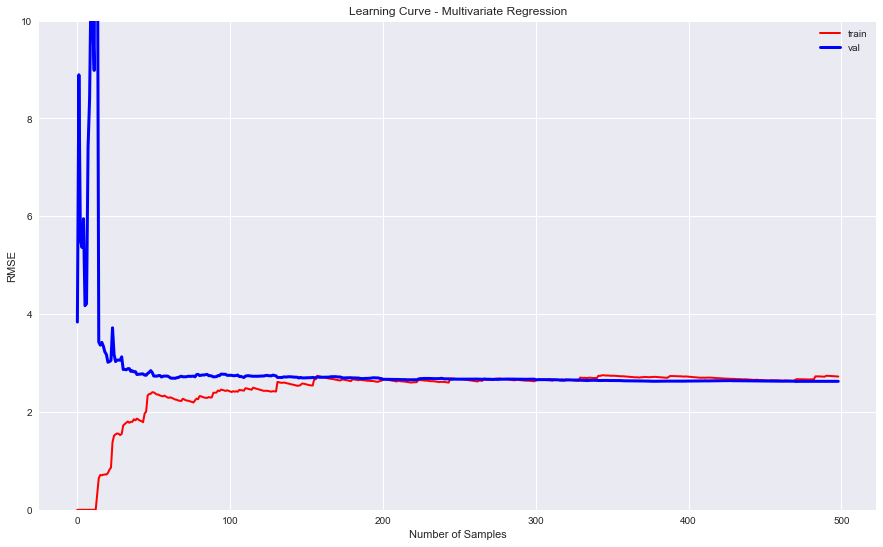

In [53]:
X = df_sample[predictors]
y = df_sample[target[0]]
lin_reg = LinearRegression()
plot_learning_curves_multi(lin_reg, X, y)

##### Polynomial Regression

The polynomial regression models needed even more testing data points for the validation dataset performance to converge with the training data

In [54]:
def plot_learning_curves_poly(X, y, degree):
#     degree = degree
    reg_simple_df = MyLinearRegression([target[0],single_var[0]], cab_type_global, ride_type_global)
    X_train, X_val, y_train, y_val = reg_simple_df.split_data()
    df_filter = reg_simple_df.split_data()   
    X_train = df_filter[0][single_var[0]].values
    X_test = df_filter[1][single_var[0]].values
    y_train = df_filter[2].values
    y_test = df_filter[3].values
    combined_df = pd.DataFrame(columns = ['y_train', 'x_train'])
    combined_df['y_train'] = y_train
    combined_df['X_tran'] = X_train
    train_errors, val_errors = [], []
    for m in range(1, 500):
        model = np.polyfit(X_train[:m], y_train[:m],degree)
        model = np.poly1d(model)
        y_train_predict = model(X_train[:m])
        y_val_predict = model(X_val)
        train_errors.append(metrics.mean_squared_error(y_train[:m], y_train_predict))
        val_errors.append(metrics.mean_squared_error(y_val, y_val_predict))
    plt.figure(figsize = (15,9))
    plt.plot(np.sqrt(train_errors), "r-+", linewidth=2, label="train")
    plt.plot(np.sqrt(val_errors), "b-", linewidth=3, label="val")
    plt.title('Learning Curve - Polynomial Regression')
    plt.xlabel('Number of Samples')
    plt.ylabel('RMSE')
    plt.legend(loc = 'upper right')
    plt.ylim((0,10))
    return plt.plot()


C:\Users\oshapira\AppData\Local\Continuum\Anaconda3\lib\site-packages\ipykernel_launcher.py:5: RankWarning:

Polyfit may be poorly conditioned

C:\Users\oshapira\AppData\Local\Continuum\Anaconda3\lib\site-packages\ipykernel_launcher.py:5: RankWarning:

Polyfit may be poorly conditioned

C:\Users\oshapira\AppData\Local\Continuum\Anaconda3\lib\site-packages\ipykernel_launcher.py:5: RankWarning:

Polyfit may be poorly conditioned



[]

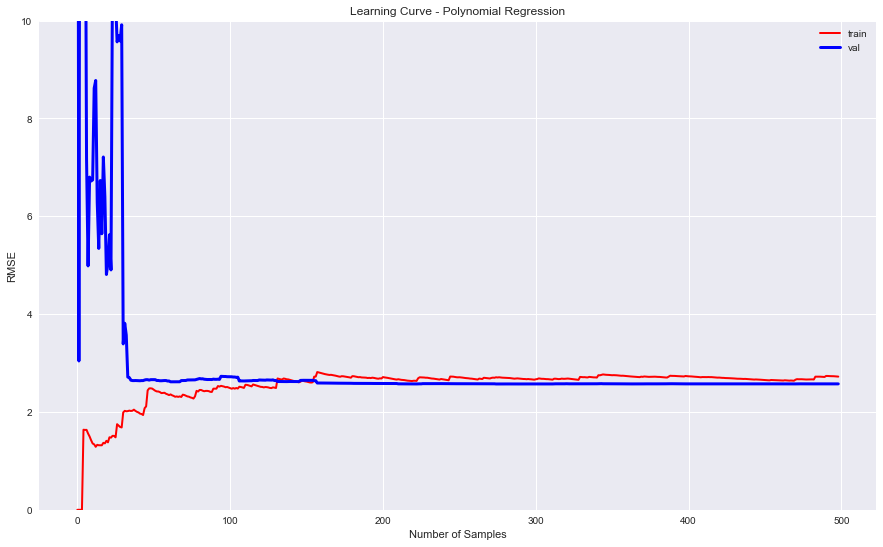

In [55]:
X = df_sample[single_var[0]]
y = df_sample[target[0]]


plot_learning_curves_poly(X, y, 3)

## K - Nearest Neighbors Regression

The next type of regression model I explored was K-Nearest Neighbors (kNN). This model predicts values by taking the mean target value of it's closet K neighbors. Proximity of neighbors is determined by simiarlity in features.

My first step was to build a Class Object, similar to the one I had made for linear and polynomial regression. 

In [56]:


######################KNN REGRESSION##################
from sklearn.neighbors import KNeighborsRegressor
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn import neighbors




class MyKnnRegression:    
    def __init__(self, features, cab_type, ride_type, K, p): #build instance
        self.features= features
        self.cab_type = cab_type
        self.ride_type = ride_type  
        self.K = K
        self.p = p
    def filter_data(self):
        self.features = self.features

        df_filter_features = df_sample.loc[(df_sample['ride_type'].isin(self.ride_type)) & (df_sample['cab_type'].isin(self.cab_type))]
        df_filter = df_filter_features.filter(items = self.features)
        df_filter[target[0]] = df_filter_features[target[0]]
        if any('weekday' in s for s in df_filter.columns):
            df_encode = df_filter['weekday']
            df_filter = pd.concat([df_filter, pd.get_dummies(df_encode, prefix = 'Day', drop_first = True)], axis = 1)
            df_filter.drop(['weekday'], axis=1, inplace = True)
            df_filter = df_filter.reset_index(drop = True)
        else:
            df_filter = df_filter.reset_index(drop = True)                
        return df_filter

    def split_data(self):
        df_filter = self.filter_data()
        X = df_filter.loc[:, df_filter.columns != target[0]]
        Y = df_filter[target[0]]
        scaler = StandardScaler()
        scaler.fit(X)
        X = scaler.transform(X)
        X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size = 0.2, random_state = 0)
        return X_train, X_test, y_train, y_test

    def create_model(self):
        X_train, X_test, y_train, y_test = self.split_data()
        model_cab = neighbors.KNeighborsRegressor(n_neighbors = self.K, p = self.p)
        model_cab.fit(X_train, y_train)
        return model_cab


    def predict_model(self):
        X_train, X_test, y_train, y_test = self.split_data()
        return_model = self.create_model()
        fit_model = return_model.fit(X_train, y_train)
        predict = return_model.predict(X_test)
        return predict


    def metric_r2(self):
        X_train, X_test, y_train, y_test = self.split_data()
        return_model = self.create_model()
        fit_model = return_model.fit(X_train, y_train)
        r2_score = return_model.score(X_test, y_test)
        return round(r2_score,3)

    def metric_MAE(self):
        predicted = self.predict_model()        
        model_cab = self.create_model()
        X_train, X_test, y_train, y_test = self.split_data()
        model_cab.fit(X_train, y_train)
        MAE= metrics.mean_absolute_error(predicted, y_test)
        return round(MAE,3)

    def metric_MSE(self):
        predicted = self.predict_model()        
        model_cab = self.create_model()
        X_train, X_test, y_train, y_test = self.split_data()
        model_cab.fit(X_train, y_train)
        MSE= metrics.mean_squared_error(predicted, y_test)
        return round(MSE,3)

    def metric_RMSE(self):
        predicted = self.predict_model()        
        model_cab = self.create_model()
        X_train, X_test, y_train, y_test = self.split_data()
        model_cab.fit(X_train, y_train)
        RMSE= np.sqrt(metrics.mean_squared_error(predicted, y_test))
        return round(RMSE,3)
    
    def metric_adj_r2(self):
        X_train, X_test, y_train, y_test = self.split_data()
        predicted = self.predict_model() 
        r2_score = metrics.r2_score(y_test, predicted)
        adj_r2 = 1 - (1-r2_score)*(len(y_test)-1)/(len(y_test)-1-1)
        return round(adj_r2,3)

    
    def predict_model_train(self):
        X_train, X_test, y_train, y_test = self.split_data()
        return_model = self.create_model()
        fit_model = return_model.fit(X_train, y_train)
        predict = return_model.predict(X_train)
        return predict
    
    def metric_r2_train(self):
        X_train, X_test, y_train, y_test = self.split_data()
        return_model = self.create_model()
        fit_model = return_model.fit(X_train, y_train)
        r2_score = return_model.score(X_train, y_train)
        return round(r2_score,3)

    def metric_MAE_train(self):
        predicted = self.predict_model_train()        
        model_cab = self.create_model()
        X_train, X_test, y_train, y_test = self.split_data()
        model_cab.fit(X_train, y_train)
        MAE= metrics.mean_absolute_error(predicted, y_train)
        return round(MAE,3)

    def metric_MSE_train(self):
        predicted = self.predict_model_train()        
        model_cab = self.create_model()
        X_train, X_test, y_train, y_test = self.split_data()
        model_cab.fit(X_train, y_train)
        MSE= metrics.mean_squared_error(predicted, y_train)
        return round(MSE,3)

    def metric_RMSE_train(self):
        predicted = self.predict_model_train()        
        model_cab = self.create_model()
        X_train, X_test, y_train, y_test = self.split_data()
        model_cab.fit(X_train, y_train)
        RMSE= np.sqrt(metrics.mean_squared_error(predicted, y_train))
        return round(RMSE,3)
    
    
    def metric_adj_r2_train(self):
        X_train, X_test, y_train, y_test = self.split_data()
        predicted = self.predict_model_train() 
        r2_score = metrics.r2_score(y_train, predicted)
        adj_r2 = 1 - (1-r2_score)*(len(y_train)-1)/(len(y_train)-1-1)
        return round(adj_r2,3)
    
    

The next thing I wanted to determine was what the optimal number of K - neighbors should be. I approached this with two different methods:

#### Elbow Method for Determining K-Neighbors

Below, I plotted the RMSE for predictions against the test dataset for each value of K-neighbors. One popular approach for choosing K is looking for the "elbow" bend in this plot. This is the point at which increasing K has minimal impact on decreasing RMSE. In the plot below, it's easy to see that K = 9 is the optimal point, since RMSE happens to increase at K = 11. However, sometimes this method is tougher to implement. Also, I wanted a programmatic way to select K. 

Additionally, kNN Regression Models can also use different formulas for calculating distance between neighbors. The default (p = 2) uses the Euclidean method. However, I wanted to see whether the Minkowski method (p = 1) performed any better.

In [57]:
# from sklearn.metrics import mean_squared_error 
from math import sqrt
import plotly.express as px
import plotly.graph_objects as go
from plotly.offline import plot

def knn_regression_filter(variables, cab_type, ride_type):
    rmse_val = [] #to store rmse values for different k
    k_list = []

    for K in range(3,17,2):
        K = K
        returned_knn = MyKnnRegression(variables, cab_type, ride_type, K, 2)
        X_train, X_test, y_train, y_test = returned_knn.split_data()
        error = returned_knn.metric_RMSE()
        rmse_val.append(error) #store rmse values
        k_list.append(K)
#        printed = print('RMSE value for k= ' , K , 'is:', error, 'and R-square is ', str(round(r2,2)))
    curve = pd.DataFrame(rmse_val,k_list).reset_index(drop = False) #elbow curve 
    curve.columns = ['k_value', 'rmse']
    k_array = np.asarray(k_list)
    rmse_val_array = np.asarray(rmse_val)

    fig = go.Figure(data = go.Scatter(x= curve['k_value'], y=curve['rmse']))
    fig.update_layout(
            title = 'Accuracy per number of K Neighbors',
            xaxis = dict(
                    tick0 = 3,
                    dtick = 2,
                    title_text = '# of Neighbors'
                    ),
            yaxis = dict(
                    title_text = 'Root Mean Squared Error')
                )

    return iplot(fig)


knn_regression_filter(all_variables, cab_type_global, ride_type_global)


#### Grid-Search Method for Determining K Neighbors

Python has a usueful grid-search function for hytertuning models to their optimal paramaters.

In the GridSearch function, there are several key parameters to specify:
 - estimator: The type of model being used to fit values - in this case KNeighborsRegressor
 - param_grid: The paramater values to iteratate through. In this case, I created a param_grid that specified a list of different p distance values and n_neighbors to evaluate
 - cv: GridSearch uses stratified cross-fold validation for testing the performance of each parameter set. This technique divides the training data into k equally-sized groups (in this case 3). Then, k-1 folds are used for training the model, while the remaining fold is used for validation testing. This process is repeated for each combination of training and test folds, and the average score is then calculated across all retained evaluation scores. 
 - n_jobs: Number of jobs running in parallel. -1 means using all processors.
 - scoring: The scoring evaluation method used to determine performance. I used r2, which is the default scoring metric for regression models.


In [58]:
n_neighbors = [3, 5, 7, 9, 11, 13, 15]
p_dist = [1, 2]

In [59]:
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import StratifiedKFold
# Create the parameter grid based on the results of random search 
    
param_grid = {
    'p': p_dist,
    'n_neighbors': n_neighbors


}
# Create a based model
knn = KNeighborsRegressor()
# Instantiate the grid search model
grid_search = GridSearchCV(estimator = knn, param_grid = param_grid, 
                          cv = 3, n_jobs = -1, scoring = 'r2')


returned_knn = MyKnnRegression(all_variables, cab_type_global, ride_type_global, 7, 2) ##dummy parameter values
X_train, X_test, y_train, y_test = returned_knn.split_data()
grid_search.fit(X_train, y_train)

GridSearchCV(cv=3, error_score=nan,
             estimator=KNeighborsRegressor(algorithm='auto', leaf_size=30,
                                           metric='minkowski',
                                           metric_params=None, n_jobs=None,
                                           n_neighbors=5, p=2,
                                           weights='uniform'),
             iid='deprecated', n_jobs=-1,
             param_grid={'n_neighbors': [3, 5, 7, 9, 11, 13, 15], 'p': [1, 2]},
             pre_dispatch='2*n_jobs', refit=True, return_train_score=False,
             scoring='r2', verbose=0)

The results of the GridSearch show the optimal number of K neighbors is 11, and distance metrics is Euclidean (2). This happens to match the optimal value in the prior plot using the elbow method, which makes sense. However, it's important to remember that performance in models may vary due to various reasons like:

1.) GridSearch used a cross-fold validation technique, rather than the hold-out method I had used in the elbow-method plot. 
2.) GridSearch used r2 as the performance metric rather than RMSE.

I proceeded using the grid-search values, and converted the results to a list. This way, the optimal values could be passed into other functions.

In [60]:
params = grid_search.best_params_['n_neighbors'],grid_search.best_params_['p']
params = list(params)
params


[11, 2]

In [61]:
grid_search.cv_results_

{'mean_fit_time': array([0.0156668 , 0.01633326, 0.01733335, 0.0140001 , 0.01566664,
        0.01433333, 0.01800005, 0.01333324, 0.01333332, 0.01333348,
        0.01833328, 0.02966666, 0.01333332, 0.01333308]),
 'std_fit_time': array([0.00377124, 0.00402779, 0.00418993, 0.00141417, 0.00385855,
        0.00047148, 0.00707112, 0.00047143, 0.00047154, 0.00047143,
        0.00684767, 0.02286663, 0.00047137, 0.00047137]),
 'mean_score_time': array([0.02966658, 0.01800013, 0.02733334, 0.02499994, 0.046     ,
        0.02966666, 0.03066675, 0.02966674, 0.03100006, 0.03633324,
        0.06100011, 0.0370001 , 0.03833342, 0.04166675]),
 'std_score_time': array([1.58395571e-02, 8.16437402e-04, 8.25969802e-03, 2.44960421e-03,
        2.69197017e-02, 5.18557965e-03, 2.62477176e-03, 9.42684517e-04,
        1.12391596e-07, 4.71409691e-03, 3.68056596e-02, 8.16437410e-04,
        1.24712873e-03, 4.10969824e-03]),
 'param_n_neighbors': masked_array(data=[3, 3, 5, 5, 7, 7, 9, 9, 11, 11, 13, 13, 15, 15],


I visualized the results of the GridSearch (above) and plotted the performance of different K and p values below.

In [62]:
scores_mean = grid_search.cv_results_['mean_test_score']
scores_mean = np.array(scores_mean).reshape(len(p_dist),len(n_neighbors))
mean_p1 = scores_mean[:,0]
mean_p2 = scores_mean[:,1]
scores_mean = np.stack((mean_p1, mean_p2), axis = 0)
scores_mean

array([[0.28857916, 0.4070841 ],
       [0.32848066, 0.36663568]])

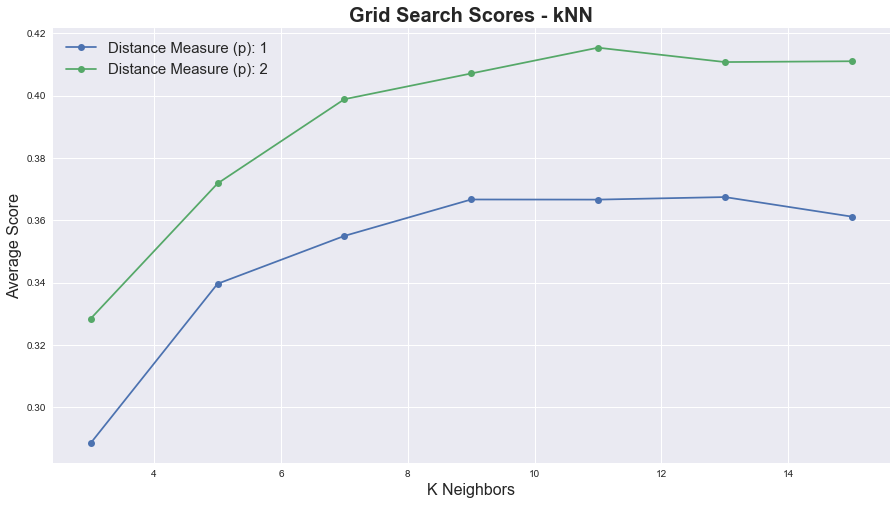

In [63]:
def plot_grid_search(cv_results, grid_param_1, grid_param_2, name_param_1, name_param_2):
    # Get Test Scores Mean and std for each grid search
    scores_mean = grid_search.cv_results_['mean_test_score']
    scores_mean = np.array(scores_mean).reshape(len(grid_param_1),len(grid_param_2))
    mean_p1 = scores_mean[:,0]
    mean_p2 = scores_mean[:,1]
    scores_mean = np.stack((mean_p1, mean_p2), axis = 0)

    fig, ax = plt.subplots(1,1, figsize = (15, 8))

    # Param1 is the X-axis, Param 2 is represented as a different curve (color line)
    for idx, val in enumerate(grid_param_2):
        ax.plot(grid_param_1, scores_mean[idx,:], '-o', label= name_param_2 + ': ' + str(val))

    ax.set_title("Grid Search Scores - kNN", fontsize=20, fontweight='bold')
    ax.set_xlabel(name_param_1, fontsize=16)
    ax.set_ylabel('Average Score', fontsize=16)
    ax.legend(loc="best", fontsize=15)
    ax.grid('on')
    
#     ax.figsize(15,8)

# Calling Method 
plot_grid_search(grid_search.cv_results_, n_neighbors, p_dist, 'K Neighbors', 'Distance Measure (p)')

To verify whether GridSearch was picking optimal parameters that improved performance on my validation data, I compared the RMSE and r2 of my kNN model using the default baseline parameters (k = 5, p =2) compared to my new optimal parameters. You can see that the with my optimized model, r2 increased and RMSE decreased significantly - as expected.

In [64]:
#  features, cab_type, ride_type, n_est, max_feat, max_depth, min_samp_split, min_samp_leaf, bootstrap)
    
knn_baseline = MyKnnRegression(all_variables, cab_type_global, ride_type_global, 5, 2)
knn_baseline_r2 = knn_baseline.metric_r2()
knn_baseline_rmse = knn_baseline.metric_RMSE()

print("For the baseline model, r-squared is " + str(knn_baseline_r2) + "\n"
      "and the RMSE is " + str(knn_baseline_rmse))

For the baseline model, r-squared is 0.417
and the RMSE is 2.917


In [65]:
#  features, cab_type, ride_type, n_est, max_feat, max_depth, min_samp_split, min_samp_leaf, bootstrap)
    
knn_baseline = MyKnnRegression(all_variables, cab_type_global, ride_type_global, params[0], params[1])
knn_baseline_r2 = knn_baseline.metric_r2()
knn_baseline_rmse = knn_baseline.metric_RMSE()

print("For the improved random grid-search model, r-squared is " + str(knn_baseline_r2) + "\n"
      "and the RMSE is " + str(knn_baseline_rmse))

For the improved random grid-search model, r-squared is 0.46
and the RMSE is 2.808


#### Summarize Performance Metrics of Model

In [66]:
def knn_performance_metrics(cab_type, ride_type):
    #metrics on testing validation set
    reg_simple_list = ['Simple kNN: Baseline Paramaters']
    reg_simple = MyKnnRegression([single_var[0]], cab_type,ride_type,5, 2)
    reg_simple_list.append(reg_simple.metric_r2())
    reg_simple_list.append(reg_simple.metric_MAE())
    reg_simple_list.append(reg_simple.metric_MSE())
    reg_simple_list.append(reg_simple.metric_RMSE())
    reg_simple_list.append(reg_simple.metric_adj_r2())
    ##metrics on training dataset
    reg_simple_list.append(reg_simple.metric_r2_train())
    reg_simple_list.append(reg_simple.metric_MAE_train())
    reg_simple_list.append(reg_simple.metric_MSE_train())
    reg_simple_list.append(reg_simple.metric_RMSE_train())
    reg_simple_list.append(reg_simple.metric_adj_r2_train())
    simple_df_bline = pd.DataFrame(np.asarray(reg_simple_list).reshape(1,11), 
                                   columns = ['Regression Type','r2', 'MAE', 'MSE', 'RMSE', 'Adj_R2',
                                            'r2_train', 'MAE_train', 'MSE_train', 'RMSE_train', 'Adj_R2_train'])
    

    reg_multi_list = ['Multivariate kNN: Baseline Paramaters']
    reg_multi = MyKnnRegression(all_variables, cab_type,ride_type, 5, 2)
    reg_multi_list.append(reg_multi.metric_r2())
    reg_multi_list.append(reg_multi.metric_MAE())
    reg_multi_list.append(reg_multi.metric_MSE())
    reg_multi_list.append(reg_multi.metric_RMSE())
    reg_multi_list.append(reg_multi.metric_adj_r2())
    
    reg_multi_list.append(reg_multi.metric_r2_train())
    reg_multi_list.append(reg_multi.metric_MAE_train())
    reg_multi_list.append(reg_multi.metric_MSE_train())
    reg_multi_list.append(reg_multi.metric_RMSE_train())
    reg_multi_list.append(reg_multi.metric_adj_r2_train())

    multi_df_bline = pd.DataFrame(np.asarray(reg_multi_list).reshape(1,11), 
                                        columns = ['Regression Type','r2', 'MAE', 'MSE', 'RMSE', 'Adj_R2',
                                            'r2_train', 'MAE_train', 'MSE_train', 'RMSE_train', 'Adj_R2_train'])



    #metrics on testing validation set
    reg_simple_list = ['Simple kNN: Optimized Paramaters']
    reg_simple = MyKnnRegression([single_var[0]], cab_type,ride_type,params[0], params[1])
    reg_simple_list.append(reg_simple.metric_r2())
    reg_simple_list.append(reg_simple.metric_MAE())
    reg_simple_list.append(reg_simple.metric_MSE())
    reg_simple_list.append(reg_simple.metric_RMSE())
    reg_simple_list.append(reg_simple.metric_adj_r2())
    ##metrics on training dataset
    reg_simple_list.append(reg_simple.metric_r2_train())
    reg_simple_list.append(reg_simple.metric_MAE_train())
    reg_simple_list.append(reg_simple.metric_MSE_train())
    reg_simple_list.append(reg_simple.metric_RMSE_train())
    reg_simple_list.append(reg_simple.metric_adj_r2_train())
    simple_df = pd.DataFrame(np.asarray(reg_simple_list).reshape(1,11), 
                                        columns = ['Regression Type','r2', 'MAE', 'MSE', 'RMSE', 'Adj_R2',
                                            'r2_train', 'MAE_train', 'MSE_train', 'RMSE_train', 'Adj_R2_train'])


    reg_multi_list = ['Multivariate kNN: Optimized Paramaters']
    reg_multi = MyKnnRegression(all_variables, cab_type,ride_type, params[0], params[1])
    reg_multi_list.append(reg_multi.metric_r2())
    reg_multi_list.append(reg_multi.metric_MAE())
    reg_multi_list.append(reg_multi.metric_MSE())
    reg_multi_list.append(reg_multi.metric_RMSE())
    reg_multi_list.append(reg_multi.metric_adj_r2())
    
    reg_multi_list.append(reg_multi.metric_r2_train())
    reg_multi_list.append(reg_multi.metric_MAE_train())
    reg_multi_list.append(reg_multi.metric_MSE_train())
    reg_multi_list.append(reg_multi.metric_RMSE_train())
    reg_multi_list.append(reg_multi.metric_adj_r2_train())
    multi_df = pd.DataFrame(np.asarray(reg_multi_list).reshape(1,11), 
                                        columns = ['Regression Type','r2', 'MAE', 'MSE', 'RMSE', 'Adj_R2',
                                            'r2_train', 'MAE_train', 'MSE_train', 'RMSE_train', 'Adj_R2_train'])
    
    all_dfs = [simple_df_bline, multi_df_bline, simple_df, multi_df]
    all_results_df = pd.concat(all_dfs).reset_index(drop = True)
    return all_results_df

Finally, I created a table that summarized various performance metrics of my kNN model. This was created with the same format as my Linear Regression summary results above.

Once again, my "Simple" model that only used the 'distance' variable outperformed my multivariate models, even when parameters were hypertuned.

In [67]:
knn_performance_df = knn_performance_metrics(cab_type_global, ride_type_global)
knn_performance_df

Regression Type     r2    MAE    MSE   RMSE Adj_R2  \
0         Simple kNN: Baseline Paramaters  0.502  1.994  7.271  2.696  0.501   
1   Multivariate kNN: Baseline Paramaters  0.417  2.174  8.512  2.917  0.416   
2        Simple kNN: Optimized Paramaters  0.558  1.892  6.442  2.538  0.558   
3  Multivariate kNN: Optimized Paramaters   0.46  2.083  7.884  2.808  0.459   

  r2_train MAE_train MSE_train RMSE_train Adj_R2_train  
0    0.514     2.002     7.618       2.76        0.514  
1    0.595     1.802     6.343      2.518        0.595  
2    0.537     1.966     7.254      2.693        0.537  
3     0.53     1.952     7.364      2.714         0.53

#### Plot error residuals

In [68]:
# Plot residuals
def plot_residual(cab_type, ride_type):
    
    fig, (ax1, ax2) = plt.subplots (1,2, figsize=(20,6))    
    variables = all_variables
    lin_reg_simple = MyKnnRegression(variables,cab_type,ride_type, params[0], params[1])
    X_train, X_test, y_train, y_test = lin_reg_simple.split_data()

    X_train = X_train[:, 0] ##convert to series
    X_train = np.array(X_train)
    X_train = X_train[:,np.newaxis]
    y_train = np.array(y_train)

    X_test = X_test[:, 0] ##convert to series
    X_test = np.array(X_test)
    y_test = np.array(y_test)

    model = neighbors.KNeighborsRegressor(n_neighbors = params[0], p = params[1])
    model.fit(X_train, y_train)
    # predict y from the data
    x_new = X_test
    y_new = model.predict(X_test[:, np.newaxis])
    y_new
    
    ax1.scatter(y_new, y_new - y_test, c = "blue", marker = "s", label = "Training data", alpha = 0.1)
    # plt.scatter(y_test_pred, y_test_pred - y_test, c = "lightgreen", marker = "s", label = "Validation data")
    ax1.set_title("Residual of Multivariate KNN Regression Errors")
    ax1.set_xlabel("Predicted values")
    ax1.set_ylabel("Residuals")
    ax1.legend(loc = "upper left")
    ax1.hlines(y = 0, xmin = 0, xmax = 20, color = "red")

    ax2.hist(y_new - y_test)
    ax2.set_title("Distribution of Residuals")
    ax2.set_xlabel("Residual")
    ax2.set_ylabel("Count")

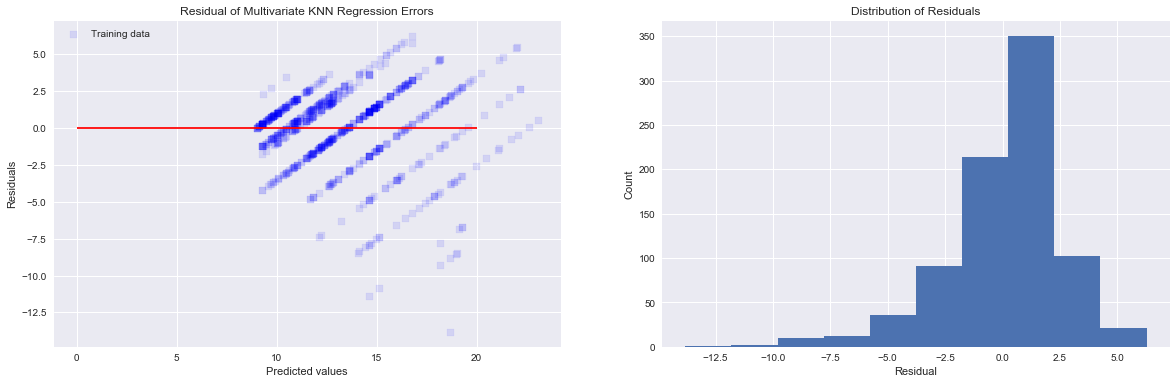

In [69]:
plot_residual(cab_type_global, ride_type_global)

In [70]:


def plot_learning_curves_knn(X, y, K, p):
    reg_simple_df = MyKnnRegression(all_variables, cab_type_global,ride_type_global,params[0], params[1])
    X_train, X_val, y_train, y_val = reg_simple_df.split_data()
    train_errors, val_errors = [], []
    for m in range(1, 1500):
#         model_cab = neighbors.KNeighborsRegressor(n_neighbors = self.K)
#         model_cab.fit(X_train, y_train)
        model = neighbors.KNeighborsRegressor(n_neighbors = K)
        model.fit(X_train[:K+m], y_train[:K+m])
        y_train_predict = model.predict(X_train[:K+m])
        y_val_predict = model.predict(X_val)
        train_errors.append(metrics.mean_squared_error(y_train[:K+m], y_train_predict))
        val_errors.append(metrics.mean_squared_error(y_val, y_val_predict))
    plt.figure(figsize = (15,9))
    plt.plot(np.sqrt(train_errors), "r-+", linewidth=2, label="train")
    plt.plot(np.sqrt(val_errors), "b-", linewidth=3, label="val")
    plt.title('Learning Curve')
    plt.xlabel('Number of Samples')
    plt.ylabel('RMSE')
    plt.legend(loc = 'upper right')
    return plt.plot()


#### Learning curves of training/validation data

Then I aggregated the performance metrics of all the linear models I tested. This time when iterating through sample sizes, I had to make sure that there were at least k+m number of samples. For example, I can't fit a model to only 2 data points for a kNN regressor that uses 5 neighbors.

[]

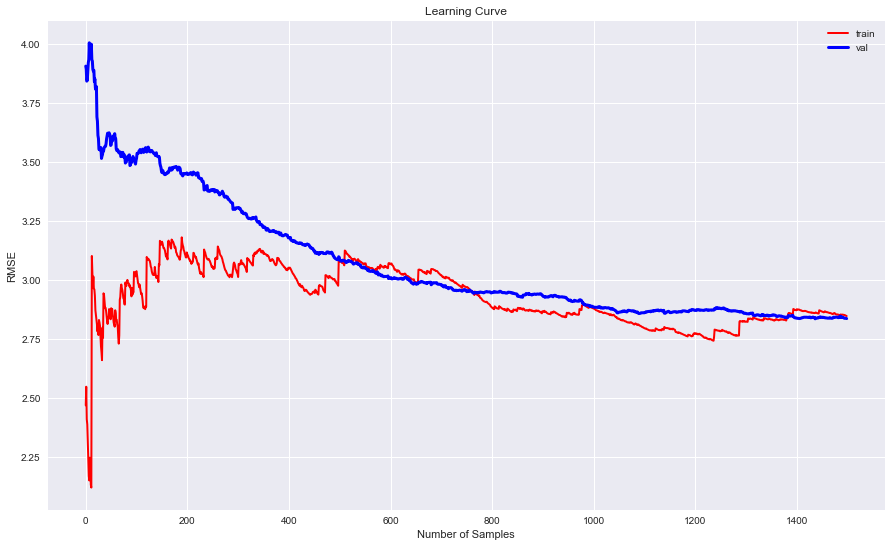

In [71]:
reg_simple_df = MyKnnRegression(all_variables, cab_type_global,ride_type_global,params[0], params[1])
return_x = reg_simple_df.filter_data()
return_x = return_x.loc[:, return_x.columns != target[0]]

X = return_x
y = df_sample[target]
plot_learning_curves_knn(X, y,params[0], params[1])


## Regression Trees

### Baseline Test of Decision Trees, Random Forest, AdaBoost and GradientBoost

The third set of regression models I wanted to test were decision trees and ensemble methods. The [article](https://towardsdatascience.com/basic-ensemble-learning-random-forest-adaboost-gradient-boosting-step-by-step-explained-95d49d1e2725) linked here gives a nice overview of comparing various ensemble methods. In brief summary:

- Decision tree make sequential, hierarchical decisions about outcome variable based on predictor data. In the tree, each node represents a decision point about a predictor variable (e.g. whether temperature is >= 50 degrees), and branches off into a lower node for either a new decision node or a final terminal/leaf node (a prediction made).
- Random Forest regression uses Bagging (Bootstrap sampling and Aggregation) to makes a series of smaller decision trees. Each tree bootstrap samples a subset of training dataset with replacement, and a random subset variables in each tree. A final prediction is made based on the aggregate of all 'random' trees.   
- AdaBoost creates small trees that learn from the errors of the prior tree created. At the end of every model, it boosts the weight of the misclassified instances so the next model does a better job on them.
- GradientBoost: Similar to Adaboost, but rather than adjust weights at every model iteration, it tries to fit the new predictor to the residual errors made by the previous predictor.




I started off by testing Decision Trees, GradientBoosting, AdaBoost, and RandomForest with baseline default parameters. I wanted to see which one would perform best.

In [72]:
from sklearn import ensemble
from sklearn import linear_model
from sklearn.tree import DecisionTreeRegressor

def test_dtree():
     ##dummy values on Knn Regrission to retrieve training and test data. Ensemble Classes will be made later
    reg_ensemble = MyKnnRegression(all_variables, cab_type_global, ride_type_global,3, 2) ##dummy values on Knn Regrission to retrieve training and test data
    # reg_simple_df = MyRFRegression(all_variables, ['Uber'],['Standard'],params[0],params[1],params[2],params[3],params[4],params[5])
    X_train, X_test, y_train, y_test = reg_ensemble.split_data()

    dtree=DecisionTreeRegressor(random_state = 2) 
    dtree.fit(X_train, y_train) 
    y_pred=dtree.predict(X_test)
    r2_score = dtree.score(X_test, y_test)
    return r2_score


test_dtree = test_dtree()

In [73]:
from sklearn import ensemble
from sklearn import linear_model
from sklearn.ensemble import GradientBoostingRegressor

def test_gb_reg():
##dummy values on Knn Regrission to retrieve training and test data. Ensemble Classes will be made later
    reg_ensemble = MyKnnRegression(all_variables, cab_type_global, ride_type_global,3, 2)
    # reg_simple_df = MyRFRegression(all_variables, ['Uber'],['Standard'],params[0],params[1],params[2],params[3],params[4],params[5])
    X_train, X_test, y_train, y_test = reg_ensemble.split_data()
    gbrt=GradientBoostingRegressor(random_state = 2)
    gbrt.fit(X_train, y_train) 
    y_pred=gbrt.predict(X_test)
    r2_score = gbrt.score(X_test, y_test)
    return r2_score

test_gb_reg = test_gb_reg()

In [74]:
from sklearn import ensemble
from sklearn import linear_model
from sklearn.ensemble import GradientBoostingRegressor

def test_gb_reg():
##dummy values on Knn Regrission to retrieve training and test data. Ensemble Classes will be made later
    reg_ensemble =MyKnnRegression(all_variables, cab_type_global, ride_type_global, 3, 2)
    X_train, X_test, y_train, y_test = reg_ensemble.split_data()
    gbrt=GradientBoostingRegressor(random_state = 2)
    gbrt.fit(X_train, y_train) 
    y_pred=gbrt.predict(X_test)
    r2_score = gbrt.score(X_test, y_test)
    return r2_score

test_gb_reg = test_gb_reg()

In [75]:
from sklearn.ensemble import AdaBoostRegressor

def test_ada_reg():
##dummy values on Knn Regrission to retrieve training and test data. Ensemble Classes will be made later
    reg_ensemble = MyKnnRegression(all_variables, cab_type_global, ride_type_global,3, 2)
    # reg_simple_df = MyRFRegression(all_variables, ['Uber'],['Standard'],params[0],params[1],params[2],params[3],params[4],params[5])
    X_train, X_test, y_train, y_test = reg_ensemble.split_data()
#     ada=AdaBoostRegressor(n_estimators=300, random_state = 2) 
    ada=AdaBoostRegressor(random_state = 2) 
    ada.fit(X_train, y_train) 
    y_pred=ada.predict(X_test)
    r2_score = ada.score(X_test, y_test)
    return r2_score

test_ada_reg = test_ada_reg()

In [76]:
from sklearn.ensemble import RandomForestRegressor

def test_rf_reg():
##dummy values on Knn Regrission to retrieve training and test data. Ensemble Classes will be made later
    reg_ensemble = MyKnnRegression(all_variables, cab_type_global, ride_type_global,3, 2)
    # reg_simple_df = MyRFRegression(all_variables, ['Uber'],['Standard'],params[0],params[1],params[2],params[3],params[4],params[5])
    X_train, X_test, y_train, y_test = reg_ensemble.split_data()
#     rf=RandomForestRegressor(n_estimators=300, random_state = 2) 
    rf=RandomForestRegressor(random_state = 2) 
    rf.fit(X_train, y_train) 
    y_pred=rf.predict(X_test)
    r2_score = rf.score(X_test, y_test)
    return r2_score


test_rf_reg = test_rf_reg()

C:\Users\oshapira\AppData\Local\Continuum\Anaconda3\lib\site-packages\seaborn\categorical.py:1428: FutureWarning:

remove_na is deprecated and is a private function. Do not use.



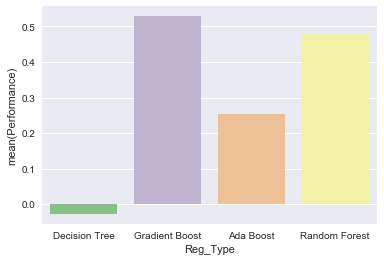

In [77]:
tree_regression_perf = [test_dtree, test_gb_reg, test_ada_reg, test_rf_reg]
tree_regression_name = ['Decision Tree', 'Gradient Boost', 'Ada Boost', 'Random Forest']


ensemble_perf = pd.DataFrame(list(zip(tree_regression_name, tree_regression_perf)), columns = ['Reg_Type', 'Performance'])
ensemble_perf


sns.barplot(ensemble_perf['Reg_Type'],ensemble_perf['Performance'],palette='Accent')

After doing a quick test of these ensemble methods, Random Forests and Gradient Boost seemed like the only ones worth exploring. Decision Trees and AdaBoost performed very poorly. Decision trees had a negative r2 score, meaning that it would perform worse than simply predicting the target variable's mean value in a dataset. I assume this was due to overfitting, since no pruning/hyperparameter tuning was done on the tree.

### Random Forest Regressor

My approach to build a Random Forest (RF) regerssion model was similar to the KNN and Linear Regression models tested above. My first step was building Class object that contained functions subsequently inoked for fitting and evaluating my model.

In [78]:


######################Random Forest REGRESSION##################
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import StandardScaler, LabelEncoder


class MyRFRegression:    

    

    ##initialize values for class instances
    def __init__(self, features, cab_type, ride_type, n_est, max_feat, max_depth, min_samp_split, min_samp_leaf, bootstrap): #build instance
        self.features= features
        self.cab_type = cab_type
        self.ride_type = ride_type  
        self.n_est = n_est
        self.max_feat = max_feat
        self.max_depth = max_depth
        self.min_samp_split = min_samp_split
        self.min_samp_leaf = min_samp_leaf
        self.bootstrap = bootstrap
##filter data based on cab type, ride type, and features of interest
    def filter_data(self):
        self.features = self.features    
#         df_filter_features = df.loc[(df['ride_type'].isin(self.ride_type)) & (df['cab_type'].isin(self.cab_type))]
#         df_filter = df_filter_features.filter(items = self.features)
#         df_sample = df.sample(50000, random_state = 2)
#         df_sample[df_sample[target[0]] < 100]
        df_filter_features = df_sample.loc[(df_sample['ride_type'].isin(self.ride_type)) & (df_sample['cab_type'].isin(self.cab_type))]
        df_filter = df_filter_features.filter(items = self.features)
        df_filter[target[0]] = df_filter_features[target[0]]
        if any('weekday' in s for s in df_filter.columns):
            df_encode = df_filter['weekday']
            df_filter = pd.concat([df_filter, pd.get_dummies(df_encode, prefix = 'Day', drop_first = True)], axis = 1)
            df_filter.drop(['weekday'], axis=1, inplace = True)
            df_filter = df_filter.reset_index(drop = True)
        else:
            df_filter = df_filter.reset_index(drop = True)                
        return df_filter

##partition training/test datasets by 80/20%, respectively
    def split_data(self):
        df_filter = self.filter_data()
        X = df_filter.loc[:, df_filter.columns != target[0]]
        Y = df_filter[target[0]]
    #    X = sm.add_constant(X)
        scaler = StandardScaler()
        scaler.fit(X)
        X = scaler.transform(X)
        X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size = 0.2, random_state = 0)
        return X_train, X_test, y_train, y_test

#function to create validation model
    def create_model(self):
        X_train, X_test, y_train, y_test = self.split_data()
        model_cab = RandomForestRegressor(n_estimators = self.n_est, max_features = self.max_feat, 
            max_depth = self.max_depth, min_samples_split = self.min_samp_split, min_samples_leaf = self.min_samp_leaf,
            bootstrap = self.bootstrap, random_state = 0)
        model_cab.fit(X_train, y_train)
        return model_cab

##function to create predictions for validation dataset, fitted from training dataset
    def predict_model(self):
        X_train, X_test, y_train, y_test = self.split_data()
        return_model = self.create_model()
        fit_model = return_model.fit(X_train, y_train)
        predict = return_model.predict(X_test)
        return predict

    def metric_r2(self):
        X_train, X_test, y_train, y_test = self.split_data()
        return_model = self.create_model()
        fit_model = return_model.fit(X_train, y_train)
        r2_score = return_model.score(X_test, y_test)
        return round(r2_score,3)

    def metric_MAE(self):
        predicted = self.predict_model()        
        model_cab = self.create_model()
        X_train, X_test, y_train, y_test = self.split_data()
        model_cab.fit(X_train, y_train)
        MAE= metrics.mean_absolute_error(predicted, y_test)
        return round(MAE,3)

    def metric_MSE(self):
        predicted = self.predict_model()        
        model_cab = self.create_model()
        X_train, X_test, y_train, y_test = self.split_data()
        model_cab.fit(X_train, y_train)
        MAE= metrics.mean_squared_error(predicted, y_test)
        return round(MAE,3)

    def metric_RMSE(self):
        predicted = self.predict_model()        
        model_cab = self.create_model()
        X_train, X_test, y_train, y_test = self.split_data()
        model_cab.fit(X_train, y_train)
        MAE= np.sqrt(metrics.mean_squared_error(predicted, y_test))
        return round(MAE,3)

    def metric_adj_r2(self):
        X_train, X_test, y_train, y_test = self.split_data()
        return_model = self.create_model()
        fit_model = return_model.fit(X_train, y_train)
        r2_score = return_model.score(X_test, y_test) 
        adj_r2 = 1 - (1-r2_score)*(len(y_test)-1)/(len(y_test)-X_test.shape[1]-1)
        return round(adj_r2,3)

    
    def predict_model_train(self):
        X_train, X_test, y_train, y_test = self.split_data()
        return_model = self.create_model()
        fit_model = return_model.fit(X_train, y_train)
        predict = return_model.predict(X_train)
        return predict
    
    def metric_r2_train(self):
        X_train, X_test, y_train, y_test = self.split_data()
        return_model = self.create_model()
        fit_model = return_model.fit(X_train, y_train)
        r2_score = return_model.score(X_train, y_train)
        return round(r2_score,3)

    def metric_MAE_train(self):
        predicted = self.predict_model_train()        
        model_cab = self.create_model()
        X_train, X_test, y_train, y_test = self.split_data()
        model_cab.fit(X_train, y_train)
        MAE= metrics.mean_absolute_error(predicted, y_train)
        return round(MAE,3)

    def metric_MSE_train(self):
        predicted = self.predict_model_train()        
        model_cab = self.create_model()
        X_train, X_test, y_train, y_test = self.split_data()
        model_cab.fit(X_train, y_train)
        MAE= metrics.mean_squared_error(predicted, y_train)
        return round(MAE,3)

    def metric_RMSE_train(self):
        predicted = self.predict_model_train()        
        model_cab = self.create_model()
        X_train, X_test, y_train, y_test = self.split_data()
        model_cab.fit(X_train, y_train)
        MAE= np.sqrt(metrics.mean_squared_error(predicted, y_train))
        return round(MAE,3)
    
    def metric_adj_r2_train(self):
        X_train, X_test, y_train, y_test = self.split_data()
        return_model = self.create_model()
        fit_model = return_model.fit(X_train, y_train)
        r2_score = return_model.score(X_train, y_train) 
        adj_r2 = 1 - (1-r2_score)*(len(y_train)-1)/(len(y_train)-X_train.shape[1]-1)
        return round(adj_r2,3)  
    
    ##return importance of features in training dataset
    def feature_importance(self):
        feature_list = self.features
        model_cab = self.create_model()
        X_train, X_test, y_train, y_test = self.split_data()
        model_cab.fit(X_train, y_train)
        importances = list(model_cab.feature_importances_)
        # List of tuples with variable and importance
        feature_importances = [(feature, round(importance, 2)) for feature, importance in zip(feature_list, importances)]
        # Sort the feature importances by most important first
        feature_importances = sorted(feature_importances, key = lambda x: x[1], reverse = True)
        # Print out the feature and importances 
        feature_ranking = [print('Variable: {:20} Importance: {}'.format(*pair)) for pair in feature_importances];
        return feature_ranking
    
    
    

To improve performance on my baseline RF model, I hypertuned the parameters for optimal performance on the training dataset. The parameters I chose to focus on were:

- n_estimators: The number of trees created on my forest (collection of Decision Tree subsets).
- max_features: The number of features to consider when looking for the best split
- max_depth: The maximum depth of each tree. The deeper the tree, the more splits it has and more information is captured. 
- min_samples_leaf: The minimum number of samples required to be a terminal leaf node. 
- min_samples_split: The minimum number of samples required to split an internal node. 
- bootstrap: Whether bootstrap sampling used to build trees. If False, entire dataset will be used.

#### RandomizedSearchCV for Hypertuning

Since there are many parameters with a wide range of values to iterate through, I chose to use Python's RandomizedSearchCV. This functions similar to the GridSearch discussed above, but it only evaluates performance for a random subset of parameters specified in my 'random_grid' below. This significantly reduces computation time, and helps me narrow done the general range of values optimal for my paramater.

In [79]:
n_estimators = [5, 10, 20, 50, 100, 150, 300, 500]
# Number of features to consider at every split
max_features = ['auto', 'sqrt', 2]
# Maximum number of levels in tree
max_depth = [int(x) for x in np.linspace(5, 100, num = 5)]
max_depth.append(None)
# Minimum number of samples required to split a node
min_samples_split = [2, 5, 10]
# Minimum number of samples required at each leaf node
min_samples_leaf = [1, 2, 4]
# Method of selecting samples for training each tree
bootstrap = [True, False]
# Create the random grid
random_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap}
print(random_grid)

{'n_estimators': [5, 10, 20, 50, 100, 150, 300, 500], 'max_features': ['auto', 'sqrt', 2], 'max_depth': [5, 28, 52, 76, 100, None], 'min_samples_split': [2, 5, 10], 'min_samples_leaf': [1, 2, 4], 'bootstrap': [True, False]}


In [80]:
from sklearn.model_selection import RandomizedSearchCV
# Use the random grid to search for best hyperparameters
# First create the base model to tune
rf = RandomForestRegressor()
# Random search of parameters, using 3 fold cross validation, 
# search across 100 different combinations, and use all available cores
rf_random = RandomizedSearchCV(estimator = rf, param_distributions = random_grid, n_iter = 50, cv = 3, verbose=2, random_state=42, n_jobs = -1, scoring='r2')
# Fit the random search model
returned_rf = MyRFRegression(all_variables, cab_type_global, ride_type_global, 10, None, None, 2, 1, True)
X_train, X_test, y_train, y_test = returned_rf.split_data()
rf_random.fit(X_train, y_train)

Fitting 3 folds for each of 50 candidates, totalling 150 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed:   15.3s
[Parallel(n_jobs=-1)]: Done 150 out of 150 | elapsed:  1.1min finished


RandomizedSearchCV(cv=3, error_score=nan,
                   estimator=RandomForestRegressor(bootstrap=True,
                                                   ccp_alpha=0.0,
                                                   criterion='mse',
                                                   max_depth=None,
                                                   max_features='auto',
                                                   max_leaf_nodes=None,
                                                   max_samples=None,
                                                   min_impurity_decrease=0.0,
                                                   min_impurity_split=None,
                                                   min_samples_leaf=1,
                                                   min_samples_split=2,
                                                   min_weight_fraction_leaf=0.0,
                                                   n_estimators=100,
                              

In [81]:
rf_random.best_params_

{'n_estimators': 100,
 'min_samples_split': 10,
 'min_samples_leaf': 2,
 'max_features': 'auto',
 'max_depth': 5,
 'bootstrap': True}

In [82]:
rs_param = rf_random.best_params_['n_estimators'],rf_random.best_params_['max_features'],rf_random.best_params_['max_depth'],rf_random.best_params_['min_samples_split'],rf_random.best_params_['min_samples_leaf'],rf_random.best_params_['bootstrap']
rs_param = list(rs_param)
rs_param

[100, 'auto', 5, 10, 2, True]

Once the best parameter values from my 'Randomized Search' were identified (seen above), I checked whether it improved performance on my validation dataset compared to the baseline default values

In [83]:
rf_baseline = MyRFRegression(all_variables, cab_type_global, ride_type_global, 10, None, None, 2, 1, True) #default param values
rf_baseline_r2 = rf_baseline.metric_r2()
rf_baseline_rmse = rf_baseline.metric_RMSE()

print("For the baseline model, r-squared is " + str(rf_baseline_r2) + "\n"
      "and the RMSE is " + str(rf_baseline_rmse))

For the baseline model, r-squared is 0.456
and the RMSE is 2.818


In [84]:
#  features, cab_type, ride_type, n_est, max_feat, max_depth, min_samp_split, min_samp_leaf, bootstrap)
    
rf_improved = MyRFRegression(all_variables, cab_type_global, ride_type_global, rs_param[0],rs_param[1],rs_param[2],rs_param[3],rs_param[4],rs_param[5])
rf_improved_r2 = rf_improved.metric_r2()
rf_improved_rmse = rf_improved.metric_RMSE()

print("For the improved random-search model, r-squared is " + str(rf_improved_r2) + "\n"
      "and the RMSE is " + str(rf_improved_rmse))

For the improved random-search model, r-squared is 0.552
and the RMSE is 2.556


Using these improved parameters increased the r2 score of my validation dataset from 0.456 to 0.552 - a somewhat significant increase

#### Grid-Seach for Further Hyperparameter Tuning

Now that the best parameters from my random search have been calculated, I continued to use GridSearch to further fine-tune my model. I used the best parameters from my random search, and built a gride with nearby values below and above.

In [85]:
if rf_random.best_params_['max_depth'] is None:
    rf_random.best_params_['max_depth'] = 500
else:
    pass


est_max_f = [rf_random.best_params_['max_features']]
est_min_samp = [rf_random.best_params_['min_samples_split']]
est_min_leaf = [rf_random.best_params_['min_samples_leaf']]
est_boot = [rf_random.best_params_['bootstrap']]
est_n_est = rf_random.best_params_['n_estimators']
rf_grid_n_est = [round(est_n_est*.8), est_n_est, round(est_n_est*1.2)]
est_max_d = rf_random.best_params_['max_depth']
rf_grid_max_d = [round(est_max_d*.8), est_max_d, round(est_max_d*1.2)]

In the lists below for n_estimator and max_depth, respectively, each combination of values will be tested alongside the other parameter values (min_samples_split, min_samples_leaf, bootstrap) derived from the RandomizedSearch

In [86]:
print(rf_grid_n_est)
print(rf_grid_max_d)

[80, 100, 120]
[4, 5, 6]


In [87]:
from sklearn.model_selection import GridSearchCV
# Create the parameter grid based on the results of random search 
param_grid = {
    'bootstrap': est_boot,
    'max_depth': rf_grid_max_d,
    'max_features': est_max_f,
    'min_samples_leaf': est_min_leaf,
    'min_samples_split': est_min_samp,
    'n_estimators': rf_grid_n_est
}
# Create a based model
rf = RandomForestRegressor()
# Instantiate the grid search model
grid_search = GridSearchCV(estimator = rf, param_grid = param_grid, 
                          cv = 3, n_jobs = -1, verbose = 2, scoring='r2')


returned_rf = MyRFRegression(all_variables, cab_type_global, ride_type_global, 5, 'auto', 5, 10, 2, False) ##dummy parameter values
X_train, X_test, y_train, y_test = returned_rf.split_data()
grid_search.fit(X_train, y_train)

Fitting 3 folds for each of 9 candidates, totalling 27 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  27 out of  27 | elapsed:   12.4s finished


GridSearchCV(cv=3, error_score=nan,
             estimator=RandomForestRegressor(bootstrap=True, ccp_alpha=0.0,
                                             criterion='mse', max_depth=None,
                                             max_features='auto',
                                             max_leaf_nodes=None,
                                             max_samples=None,
                                             min_impurity_decrease=0.0,
                                             min_impurity_split=None,
                                             min_samples_leaf=1,
                                             min_samples_split=2,
                                             min_weight_fraction_leaf=0.0,
                                             n_estimators=100, n_jobs=None,
                                             oob_score=False, random_state=None,
                                             verbose=0, warm_start=False),
             iid='deprecated', n_jo

In [88]:
grid_search.best_params_

{'bootstrap': True,
 'max_depth': 4,
 'max_features': 'auto',
 'min_samples_leaf': 2,
 'min_samples_split': 10,
 'n_estimators': 100}

The new optimal parameter values are seen below. I saved these to a list to be used for subsequent functions

In [89]:
params = grid_search.best_params_['n_estimators'],grid_search.best_params_['max_features'],grid_search.best_params_['max_depth'],grid_search.best_params_['min_samples_split'],grid_search.best_params_['min_samples_leaf'],grid_search.best_params_['bootstrap']
params = list(params)
params


[100, 'auto', 4, 10, 2, True]

The plot below compares the performance score of the model with various values of max_depth and n_estimators. 

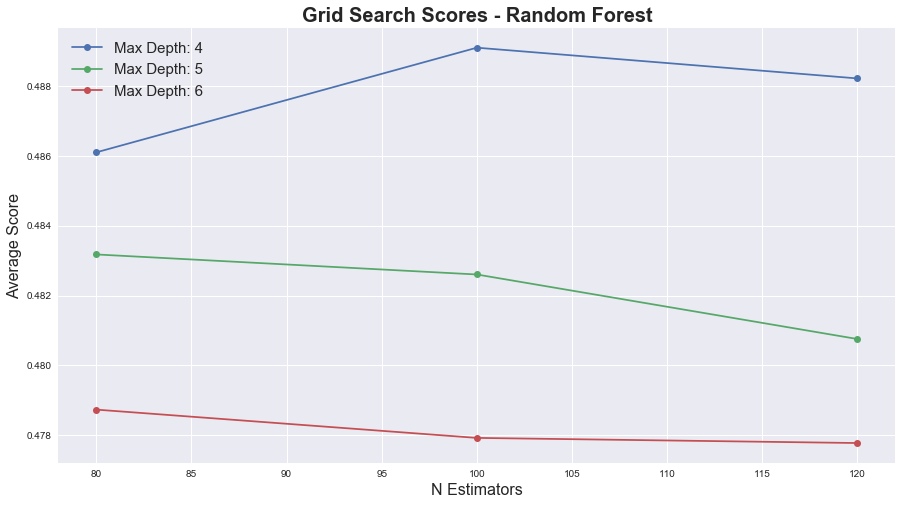

In [90]:
def plot_grid_search(cv_results, grid_param_1, grid_param_2, name_param_1, name_param_2):
    # Get Test Scores Mean and std for each grid search
    scores_mean = cv_results['mean_test_score']
    scores_mean = np.array(scores_mean).reshape(len(grid_param_2),len(grid_param_1))

    scores_sd = cv_results['std_test_score']
    scores_sd = np.array(scores_sd).reshape(len(grid_param_2),len(grid_param_1))

    # Plot Grid search scores
    fig, ax = plt.subplots(1,1, figsize = (15, 8))

    # Param1 is the X-axis, Param 2 is represented as a different curve (color line)
    for idx, val in enumerate(grid_param_2):
        ax.plot(grid_param_1, scores_mean[idx,:], '-o', label= name_param_2 + ': ' + str(val))

    ax.set_title("Grid Search Scores - Random Forest", fontsize=20, fontweight='bold')
    ax.set_xlabel(name_param_1, fontsize=16)
    ax.set_ylabel('Average Score', fontsize=16)
    ax.legend(loc="best", fontsize=15)
    ax.grid('on')

# Calling Method 
plot_grid_search(grid_search.cv_results_, rf_grid_n_est, rf_grid_max_d, 'N Estimators', 'Max Depth')

When testing the optimal parameter values on my validation data, it further improved the r2 score to 0.555

In [91]:
#  features, cab_type, ride_type, n_est, max_feat, max_depth, min_samp_split, min_samp_leaf, bootstrap)
    
rf_improved = MyRFRegression(all_variables, cab_type_global, ride_type_global, params[0], params[1], params[2],params[3],params[4],params[5])
rf_improved_r2 = rf_improved.metric_r2()
rf_improved_rmse = rf_improved.metric_RMSE()

print("For the optimal grid-search model, r-squared is " + str(rf_improved_r2) + "\n"
      "and the RMSE is " + str(rf_improved_rmse))

For the optimal grid-search model, r-squared is 0.555
and the RMSE is 2.549


#### Feature Importance

For the optimal model, distance was by far the most significant predictor of price. The other features had a very low impact.

In [92]:
returned_rf = MyRFRegression(all_variables, cab_type_global, ride_type_global, params[0], params[1], params[2],params[3],params[4],params[5])

returned_rf = returned_rf.feature_importance()
returned_rf

Variable: distance             Importance: 0.96
Variable: temperature          Importance: 0.01
Variable: windSpeed            Importance: 0.01
Variable: time                 Importance: 0.01
Variable: precipIntensity      Importance: 0.0
Variable: humidity             Importance: 0.0
Variable: weekday              Importance: 0.0
Variable: price                Importance: 0.0


[None, None, None, None, None, None, None, None]

This was also the case for the RF model with baseline parameters, though to a much lesser extent.

In [93]:
returned_rf = MyRFRegression(all_variables, cab_type_global, ride_type_global, 15, None, 15, 2, 1, True)

returned_rf.feature_importance()



Variable: distance             Importance: 0.65
Variable: time                 Importance: 0.11
Variable: windSpeed            Importance: 0.08
Variable: temperature          Importance: 0.07
Variable: humidity             Importance: 0.05
Variable: precipIntensity      Importance: 0.02
Variable: weekday              Importance: 0.01
Variable: price                Importance: 0.01


[None, None, None, None, None, None, None, None]

#### Summarize Performance Metrics of Model

As done for other mdoels, I built a dataframe that compiles the same performance metrics into a dataframe. It includes metrics for performance on the validation dataset, as well as the training dataset. 

In [94]:
def rf_performance_metrics(cab_type, ride_type):


    
    ###parameter values trained and tested on sample dataset, simple (one variable) regression
    reg_simple_list = ['Simple Random Forest - Baseline Parameters']
    reg_simple = MyRFRegression(single_var, cab_type,ride_type,10, None, None, 2, 1, True)
    reg_simple_list.append(reg_simple.metric_r2())
    reg_simple_list.append(reg_simple.metric_MAE())
    reg_simple_list.append(reg_simple.metric_MSE())
    reg_simple_list.append(reg_simple.metric_RMSE())
    reg_simple_list.append(reg_simple.metric_adj_r2())
    ##metrics on training dataset
    reg_simple_list.append(reg_simple.metric_r2_train())
    reg_simple_list.append(reg_simple.metric_MAE_train())
    reg_simple_list.append(reg_simple.metric_MSE_train())
    reg_simple_list.append(reg_simple.metric_RMSE_train())
    reg_simple_list.append(reg_simple.metric_adj_r2_train())
    simple_df_baseline_samp = pd.DataFrame(np.asarray(reg_simple_list).reshape(1,11), 
                                    columns = ['Regression Type','r2', 'MAE', 'MSE', 'RMSE', 
                                                'Adj_R2','r2_train', 'MAE_train', 'MSE_train', 
                                                'RMSE_train', 'Adj_R2_train'])

    ###parameter values trained and tested on sample dataset, all-variable regression
    reg_multi_list = ['Multivariate Random Forest - Baseline Parameters']
    reg_multi = MyRFRegression(all_variables, cab_type,ride_type, 10, None, None, 2, 1, True)
    reg_multi_list.append(reg_multi.metric_r2())
    reg_multi_list.append(reg_multi.metric_MAE())
    reg_multi_list.append(reg_multi.metric_MSE())
    reg_multi_list.append(reg_multi.metric_RMSE())
    reg_multi_list.append(reg_multi.metric_adj_r2())
   ##metrics on training dataset
    reg_multi_list.append(reg_multi.metric_r2_train())
    reg_multi_list.append(reg_multi.metric_MAE_train())
    reg_multi_list.append(reg_multi.metric_MSE_train())
    reg_multi_list.append(reg_multi.metric_RMSE_train())
    reg_multi_list.append(reg_multi.metric_adj_r2_train())
    multi_df_baseline_samp = pd.DataFrame(np.asarray(reg_multi_list).reshape(1,11), 
                                            columns = ['Regression Type','r2', 'MAE', 'MSE', 'RMSE', 
                                                'Adj_R2','r2_train', 'MAE_train', 'MSE_train', 
                                                'RMSE_train', 'Adj_R2_train'])
    
    reg_multi_list = ['Multivariate Random Forest - Improved Parameters']
    reg_multi = MyRFRegression(all_variables, cab_type,ride_type, rs_param[0],rs_param[1],rs_param[2],rs_param[3],rs_param[4],rs_param[5])
    reg_multi_list.append(reg_multi.metric_r2())
    reg_multi_list.append(reg_multi.metric_MAE())
    reg_multi_list.append(reg_multi.metric_MSE())
    reg_multi_list.append(reg_multi.metric_RMSE())
    reg_multi_list.append(reg_multi.metric_adj_r2())
    
    reg_multi_list.append(reg_multi.metric_r2_train())
    reg_multi_list.append(reg_multi.metric_MAE_train())
    reg_multi_list.append(reg_multi.metric_MSE_train())
    reg_multi_list.append(reg_multi.metric_RMSE_train())
    reg_multi_list.append(reg_multi.metric_adj_r2_train())
    multi_df_improved_samp = pd.DataFrame(np.asarray(reg_multi_list).reshape(1,11), 
                                            columns = ['Regression Type','r2', 'MAE', 'MSE', 'RMSE', 
                                                'Adj_R2','r2_train', 'MAE_train', 'MSE_train', 
                                                'RMSE_train', 'Adj_R2_train'])

    reg_multi_list = ['Multivariate Random Forest - Optimal Parameters']
    reg_multi = MyRFRegression(all_variables, cab_type,ride_type, params[0],params[1],params[2],params[3],params[4],params[5])
    reg_multi_list.append(reg_multi.metric_r2())
    reg_multi_list.append(reg_multi.metric_MAE())
    reg_multi_list.append(reg_multi.metric_MSE())
    reg_multi_list.append(reg_multi.metric_RMSE())
    reg_multi_list.append(reg_multi.metric_adj_r2())
    
    reg_multi_list.append(reg_multi.metric_r2_train())
    reg_multi_list.append(reg_multi.metric_MAE_train())
    reg_multi_list.append(reg_multi.metric_MSE_train())
    reg_multi_list.append(reg_multi.metric_RMSE_train())
    reg_multi_list.append(reg_multi.metric_adj_r2_train())
    multi_df_optimal_samp = pd.DataFrame(np.asarray(reg_multi_list).reshape(1,11), 
                                            columns = ['Regression Type','r2', 'MAE', 'MSE', 'RMSE', 
                                                'Adj_R2','r2_train', 'MAE_train', 'MSE_train', 
                                                'RMSE_train', 'Adj_R2_train'])

    reg_simple_list = ['Simple Random Forest - Optimal Parameters']
    reg_simple = MyRFRegression(single_var,cab_type,ride_type,params[0],None, params[2],params[3],params[4],params[5])
    reg_simple_list.append(reg_simple.metric_r2())
    reg_simple_list.append(reg_simple.metric_MAE())
    reg_simple_list.append(reg_simple.metric_MSE())
    reg_simple_list.append(reg_simple.metric_RMSE())
    reg_simple_list.append(reg_simple.metric_adj_r2())

    ##metrics on training dataset
    reg_simple_list.append(reg_simple.metric_r2_train())
    reg_simple_list.append(reg_simple.metric_MAE_train())
    reg_simple_list.append(reg_simple.metric_MSE_train())
    reg_simple_list.append(reg_simple.metric_RMSE_train())
    reg_simple_list.append(reg_simple.metric_adj_r2_train())

    simple_df_optimal_samp = pd.DataFrame(np.asarray(reg_simple_list).reshape(1,11), 
                                            columns = ['Regression Type','r2', 'MAE', 'MSE', 'RMSE', 
                                                'Adj_R2','r2_train', 'MAE_train', 'MSE_train', 
                                                'RMSE_train', 'Adj_R2_train'])

    
    all_dfs = [simple_df_baseline_samp, multi_df_baseline_samp, multi_df_improved_samp, multi_df_optimal_samp, simple_df_optimal_samp]
    all_results_df = pd.concat(all_dfs).reset_index(drop = True)
    return all_results_df

In [95]:
rf_performance_df = rf_performance_metrics(cab_type_global, ride_type_global)
rf_performance_df



Regression Type     r2    MAE    MSE  \
0        Simple Random Forest - Baseline Parameters  0.524  1.936  6.941   
1  Multivariate Random Forest - Baseline Parameters  0.456  2.087  7.938   
2  Multivariate Random Forest - Improved Parameters  0.552  1.949  6.531   
3   Multivariate Random Forest - Optimal Parameters  0.555  1.948  6.495   
4         Simple Random Forest - Optimal Parameters  0.558  1.931  6.452   

    RMSE Adj_R2 r2_train MAE_train MSE_train RMSE_train Adj_R2_train  
0  2.635  0.524    0.579     1.872     6.593      2.568        0.579  
1  2.818  0.448    0.887      0.89     1.772      1.331        0.887  
2  2.556  0.546    0.555     1.948     6.968       2.64        0.554  
3  2.549  0.548    0.534     1.986     7.303      2.702        0.532  
4   2.54  0.557    0.524     2.001     7.455       2.73        0.524

The simple random forest regression model (with hypertuned parameters) performed the best. It has both the highest r-squared and adjusted r-square value (which penalizes irrelevant features). 

Another observation is that the baseline models with default parameters performed very well on the training datasets, but did not generalize well on the validation data - hence the models were overfitted. I was initially surprised that the baseline models outperformed the hypertuned models on training data. But I suspect this is because the optimal parameters were identifed on training data that used the stratified cross-fold validation technique. Meanwhile, the r2 scores calculated above were done on data that was split into 80%/20% training/testing data using the hold-out technique. I plan to eventually re-calculate the r2 score of these models on training data using the sample cross-validation folding that was done for hypertuning.

#### Plot Error Residuals

In [96]:
# Plot residuals
def plot_residual(cab_type, ride_type):
    
    fig, (ax1, ax2) = plt.subplots (1,2, figsize=(20,6))    
    variables = all_variables
    lin_reg_simple = MyRFRegression(variables,cab_type,ride_type, params[0], params[1], params[2], params[3], params[4], params[5])
    X_train, X_test, y_train, y_test = lin_reg_simple.split_data()

#     X_train_plot = X_train[:, 0] ##convert to series
#     X_train_plot = np.array(X_train)
#     X_train_plot = X_train[:,np.newaxis]
#     y_train = np.array(y_train)

#     X_test_plot = X_test[:, 0] ##convert to series
#     X_test_plot = np.array(X_test)
#     y_test = np.array(y_test)

    model = RandomForestRegressor(n_estimators = params[0], max_features = params[1], 
            max_depth = params[2], min_samples_split = params[3], min_samples_leaf = params[4],
            bootstrap = params[5], random_state = 0)
    model.fit(X_train, y_train)
    y_new = model.predict(X_test)
    # predict y from the data
#     x_new = X_test
#     y_new = model.predict(X_test[:, np.newaxis])
#     y_new
    

    
    ax1.scatter(y_new, y_new - y_test, c = "blue", marker = "s", label = "Training data", alpha = 0.1)
    # plt.scatter(y_test_pred, y_test_pred - y_test, c = "lightgreen", marker = "s", label = "Validation data")
    ax1.set_title("Residual of Multivariate RF Regression Errors")
    ax1.set_xlabel("Predicted values")
    ax1.set_ylabel("Residuals")
    ax1.legend(loc = "upper left")
    ax1.hlines(y = 0, xmin = 0, xmax = 20, color = "red")

    ax2.hist(y_new - y_test)
    ax2.set_title("Distribution of Residuals")
    ax2.set_xlabel("Residual")
    ax2.set_ylabel("Count")

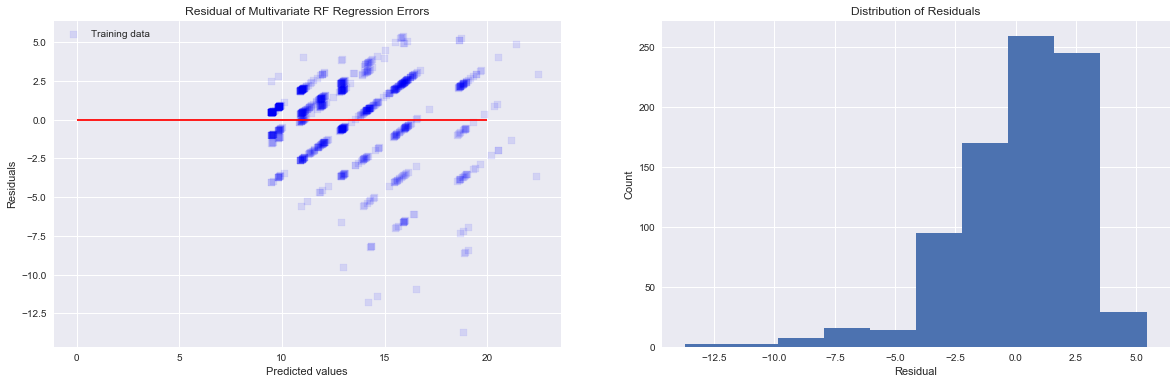

In [97]:
plot_residual(cab_type_global, ride_type_global)

The plots above showed that the error residuals are skewed left, and that price is typically overestimated.

#### Learning Curves of Training/Validation Data

The learning curves of training vs. validation data below show that the Random Forest model (using baseline parameters) did not generalize well on the validation data. Hence, the model was very overfitted on training data. 

In [98]:

def plot_learning_curves_rf(X, y, n_estimators, max_features, max_depth, min_samples_split, min_samples_leaf, bootstrap):
    reg_simple_df = MyRFRegression(all_variables, cab_type_global,ride_type_global,10, None, None, 2, 1, True)
    X_train, X_val, y_train, y_val = reg_simple_df.split_data()
    train_errors, val_errors = [], []
    for m in range(1, 300):
#         model_cab = neighbors.KNeighborsRegressor(n_neighbors = self.K)
#         model_cab.fit(X_train, y_train)
#         model = RandomForestRegressor(n_estimators = params[0], max_features = params[1], 
#             max_depth = params[2], min_samples_split = params[3], min_samples_leaf = params[4],
#             bootstrap = params[5], random_state = 0)
        model = RandomForestRegressor(n_estimators = 10, max_features = None, 
            max_depth = None, min_samples_split = 2, min_samples_leaf = 1,
            bootstrap = True, random_state = 0)
        model.fit(X_train[:m], y_train[:m])
        y_train_predict = model.predict(X_train[:m])
        y_val_predict = model.predict(X_val)
        train_errors.append(metrics.mean_squared_error(y_train[:m], y_train_predict))
        val_errors.append(metrics.mean_squared_error(y_val, y_val_predict))
    plt.figure(figsize = (15,9))
    plt.plot(np.sqrt(train_errors), "r-+", linewidth=2, label="train")
    plt.plot(np.sqrt(val_errors), "b-", linewidth=3, label="val")
    plt.title('Learning Curve')
    plt.xlabel('Number of Samples')
    plt.ylabel('RMSE')
    plt.legend(loc = 'upper right')
    return plt.plot()


[]

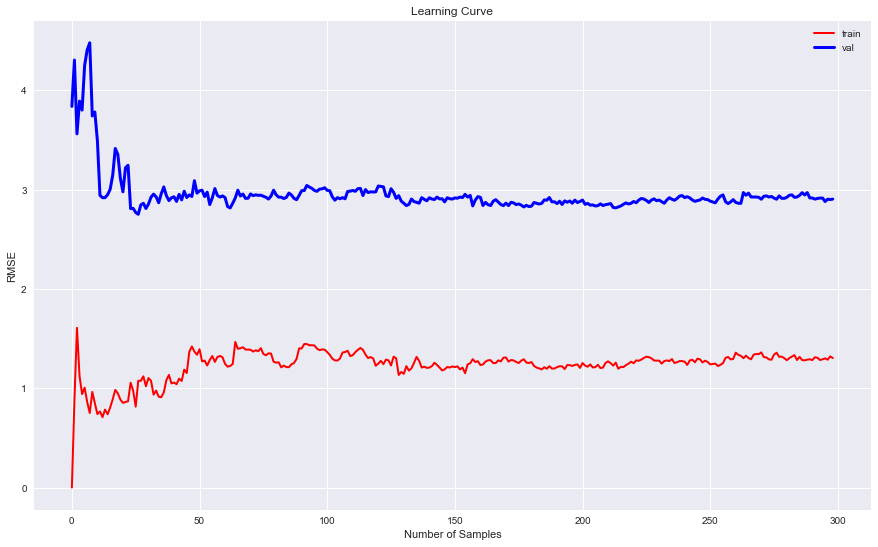

In [99]:
reg_simple_df = MyRFRegression(all_variables, cab_type_global,ride_type_global,10, None, None, 2, 1, True)
return_x = reg_simple_df.filter_data()
return_x = return_x.loc[:, return_x.columns != target[0]]

X = return_x
y = df_sample[target]
plot_learning_curves_rf(X, y,10, None, None, 2, 1, True)


### Gradient Boosting

The Other Tree Ensemble method I tested was Gradient Boosting. As done with the other models, I built a class object with functions that would be invoked in subsequent analysis.

In [100]:


######################Gradient Boosting##################
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn import ensemble
from sklearn import linear_model
from sklearn.ensemble import GradientBoostingRegressor


class MyGBRegression:    
 
    

    ##initialize values for class instances
    def __init__(self, features, cab_type, ride_type, n_est, max_feat, max_depth, min_samp_leaf): #build instance
        self.features= features
        self.cab_type = cab_type
        self.ride_type = ride_type  
        self.n_est = n_est
        self.max_feat = max_feat
        self.max_depth = max_depth
        self.min_samp_leaf = min_samp_leaf
##filter data based on cab type, ride type, and features of interest
    def filter_data(self):
        self.features = self.features    
#         df_filter_features = df.loc[(df['ride_type'].isin(self.ride_type)) & (df['cab_type'].isin(self.cab_type))]
#         df_filter = df_filter_features.filter(items = self.features)
#         df_sample = df.sample(50000, random_state = 2)
        df_filter_features = df_sample.loc[(df_sample['ride_type'].isin(self.ride_type)) & (df_sample['cab_type'].isin(self.cab_type))]
        df_filter = df_filter_features.filter(items = self.features)
        df_filter[target[0]] = df_filter_features[target[0]]
        if any('weekday' in s for s in df_filter.columns):
            df_encode = df_filter['weekday']
            df_filter = pd.concat([df_filter, pd.get_dummies(df_encode, prefix = 'Day', drop_first = True)], axis = 1)
            df_filter.drop(['weekday'], axis=1, inplace = True)
            df_filter = df_filter.reset_index(drop = True)
        else:
            df_filter = df_filter.reset_index(drop = True)                
        return df_filter

##partition training/test datasets by 80/20%, respectively
    def split_data(self):
        df_filter = self.filter_data()
        X = df_filter.loc[:, df_filter.columns != target[0]]
        Y = df_filter[target[0]]
    #    X = sm.add_constant(X)
        scaler = StandardScaler()
        scaler.fit(X)
        X = scaler.transform(X)
        X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size = 0.2, random_state = 0)
        return X_train, X_test, y_train, y_test

#function to create validation model
    def create_model(self):
        X_train, X_test, y_train, y_test = self.split_data()
        model_cab = GradientBoostingRegressor(n_estimators = self.n_est, max_features = self.max_feat, 
            max_depth = self.max_depth, min_samples_leaf = self.min_samp_leaf, random_state = 0)
        model_cab.fit(X_train, y_train)
        return model_cab

    
    
##function to create predictions for validation dataset, fitted from training dataset
    def predict_model(self):
        X_train, X_test, y_train, y_test = self.split_data()
        return_model = self.create_model()
        fit_model = return_model.fit(X_train, y_train)
        predict = return_model.predict(X_test)
        return predict

    def metric_r2(self):
        X_train, X_test, y_train, y_test = self.split_data()
        return_model = self.create_model()
        fit_model = return_model.fit(X_train, y_train)
        r2_score = return_model.score(X_test, y_test)
        return round(r2_score,3)

    def metric_MAE(self):
        predicted = self.predict_model()        
        model_cab = self.create_model()
        X_train, X_test, y_train, y_test = self.split_data()
        model_cab.fit(X_train, y_train)
        MAE= metrics.mean_absolute_error(predicted, y_test)
        return round(MAE,3)

    def metric_MSE(self):
        predicted = self.predict_model()        
        model_cab = self.create_model()
        X_train, X_test, y_train, y_test = self.split_data()
        model_cab.fit(X_train, y_train)
        MAE= metrics.mean_squared_error(predicted, y_test)
        return round(MAE,3)

    def metric_RMSE(self):
        predicted = self.predict_model()        
        model_cab = self.create_model()
        X_train, X_test, y_train, y_test = self.split_data()
        model_cab.fit(X_train, y_train)
        MAE= np.sqrt(metrics.mean_squared_error(predicted, y_test))
        return round(MAE,3)

    def metric_adj_r2(self):
        X_train, X_test, y_train, y_test = self.split_data()
        return_model = self.create_model()
        fit_model = return_model.fit(X_train, y_train)
        r2_score = return_model.score(X_test, y_test) 
        adj_r2 = 1 - (1-r2_score)*(len(y_test)-1)/(len(y_test)-X_test.shape[1]-1)
        return round(adj_r2,3)

    
    def predict_model_train(self):
        X_train, X_test, y_train, y_test = self.split_data()
        return_model = self.create_model()
        fit_model = return_model.fit(X_train, y_train)
        predict = return_model.predict(X_train)
        return predict
    
    def metric_r2_train(self):
        X_train, X_test, y_train, y_test = self.split_data()
        return_model = self.create_model()
        fit_model = return_model.fit(X_train, y_train)
        r2_score = return_model.score(X_train, y_train)
        return round(r2_score,3)

    def metric_MAE_train(self):
        predicted = self.predict_model_train()        
        model_cab = self.create_model()
        X_train, X_test, y_train, y_test = self.split_data()
        model_cab.fit(X_train, y_train)
        MAE= metrics.mean_absolute_error(predicted, y_train)
        return round(MAE,3)

    def metric_MSE_train(self):
        predicted = self.predict_model_train()        
        model_cab = self.create_model()
        X_train, X_test, y_train, y_test = self.split_data()
        model_cab.fit(X_train, y_train)
        MAE= metrics.mean_squared_error(predicted, y_train)
        return round(MAE,3)

    def metric_RMSE_train(self):
        predicted = self.predict_model_train()        
        model_cab = self.create_model()
        X_train, X_test, y_train, y_test = self.split_data()
        model_cab.fit(X_train, y_train)
        MAE= np.sqrt(metrics.mean_squared_error(predicted, y_train))
        return round(MAE,3)
    
    def metric_adj_r2_train(self):
        X_train, X_test, y_train, y_test = self.split_data()
        return_model = self.create_model()
        fit_model = return_model.fit(X_train, y_train)
        r2_score = return_model.score(X_train, y_train) 
        adj_r2 = 1 - (1-r2_score)*(len(y_train)-1)/(len(y_train)-X_train.shape[1]-1)
        return round(adj_r2,3)  
    
    ##return importance of features in training dataset
    def feature_importance(self):
        feature_list = self.features
        model_cab = self.create_model()
        X_train, X_test, y_train, y_test = self.split_data()
        model_cab.fit(X_train, y_train)
        importances = list(model_cab.feature_importances_)
        # List of tuples with variable and importance
        feature_importances = [(feature, round(importance, 2)) for feature, importance in zip(feature_list, importances)]
        # Sort the feature importances by most important first
        feature_importances = sorted(feature_importances, key = lambda x: x[1], reverse = True)
        # Print out the feature and importances 
        feature_ranking = [print('Variable: {:20} Importance: {}'.format(*pair)) for pair in feature_importances];
        return feature_ranking
    
    
    

#### RandomizedSearchCV for Hypertuning

As done with Random Forests, I used RandomizedSearchCV to narrow down the range of parameter values I would test. This time, I only focused on number of estimators, number of max featuers, max depth of trees, and minimum samples required for a leaf node. This was partly done to reduce the processing time needed for computation.

In [101]:
n_estimators = [5, 10, 20, 50, 100, 150, 300, 500]
# Number of features to consider at every split
max_features = ['auto', 'sqrt', 2]
# Maximum number of levels in tree
max_depth = [int(x) for x in np.linspace(5, 100, num = 5)]
max_depth.append(None)
# Minimum number of samples required at each leaf node
min_samples_leaf = [1, 2, 4]


# Create the random grid
random_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_leaf': min_samples_leaf}
print(random_grid)

{'n_estimators': [5, 10, 20, 50, 100, 150, 300, 500], 'max_features': ['auto', 'sqrt', 2], 'max_depth': [5, 28, 52, 76, 100, None], 'min_samples_leaf': [1, 2, 4]}


In [102]:
from sklearn.model_selection import RandomizedSearchCV
# Use the random grid to search for best hyperparameters
# First create the base model to tune
gb = GradientBoostingRegressor()
# Random search of parameters, using 3 fold cross validation, 
# search across 100 different combinations, and use all available cores
gb_random = RandomizedSearchCV(estimator = gb, param_distributions = random_grid, n_iter = 50, cv = 3, verbose=2, random_state=40, n_jobs = -1, scoring = 'r2')
# Fit the random search model
returned_gb = MyGBRegression(all_variables, cab_type_global, ride_type_global, 10, None, None, 1)
X_train, X_test, y_train, y_test = returned_gb.split_data()
gb_random.fit(X_train, y_train)

Fitting 3 folds for each of 50 candidates, totalling 150 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed:   28.7s
[Parallel(n_jobs=-1)]: Done 150 out of 150 | elapsed:  1.2min finished


RandomizedSearchCV(cv=3, error_score=nan,
                   estimator=GradientBoostingRegressor(alpha=0.9, ccp_alpha=0.0,
                                                       criterion='friedman_mse',
                                                       init=None,
                                                       learning_rate=0.1,
                                                       loss='ls', max_depth=3,
                                                       max_features=None,
                                                       max_leaf_nodes=None,
                                                       min_impurity_decrease=0.0,
                                                       min_impurity_split=None,
                                                       min_samples_leaf=1,
                                                       min_samples_split=2,
                                                       min_weight_fraction_leaf=0.0,
                             

In [103]:
gb_random.best_params_

{'n_estimators': 20,
 'min_samples_leaf': 4,
 'max_features': 'auto',
 'max_depth': 5}

The imroved parameter values are seen below.

In [104]:
rs_param = gb_random.best_params_['n_estimators'],gb_random.best_params_['max_features'],gb_random.best_params_['max_depth'],gb_random.best_params_['min_samples_leaf']
rs_param = list(rs_param)
rs_param

[20, 'auto', 5, 4]

In [105]:
if gb_random.best_params_['max_depth'] is None:
    gb_random.best_params_['max_depth'] = 500
else:
    pass


est_max_f = [gb_random.best_params_['max_features']]
est_n_est = gb_random.best_params_['n_estimators']
gb_grid_n_est = [round(est_n_est*.8), est_n_est, round(est_n_est*1.2)]
est_max_d = gb_random.best_params_['max_depth']
gb_grid_max_d = [round(est_max_d*.8), est_max_d, round(est_max_d*1.2)]

In [106]:
print(gb_grid_n_est)
print(gb_grid_max_d)

[16, 20, 24]
[4, 5, 6]


In [107]:
gb_baseline = MyGBRegression(all_variables, cab_type_global, ride_type_global, 100, None, 3, 1)
gb_baseline_r2 = gb_baseline.metric_r2()
gb_baseline_rmse = gb_baseline.metric_RMSE()

print("For the baseline model, r-squared is " + str(gb_baseline_r2) + "\n"
      "and the RMSE is " + str(gb_baseline_rmse))

For the baseline model, r-squared is 0.528
and the RMSE is 2.624


In [108]:
gb_improved = MyGBRegression(all_variables, cab_type_global, ride_type_global, rs_param[0],rs_param[1],rs_param[2],rs_param[3])
gb_improved_r2 = gb_improved.metric_r2()
gb_improved_rmse = gb_improved.metric_RMSE()

print("For the improved model, r-squared is " + str(gb_improved_r2) + "\n"
      "and the RMSE is " + str(gb_improved_rmse))

For the improved model, r-squared is 0.541
and the RMSE is 2.588


As seen above, the improved parameter values improved the r2 score on my validation dataset from 0.528 to 0.541.

#### Grid-Search for Further Hyper-Tuning

I then proceed with further fine-tuning using the Grid-search function.

In [109]:
from sklearn.model_selection import GridSearchCV
# Create the parameter grid based on the results of random search 
param_grid = {
    'max_depth': gb_grid_max_d,
    'max_features': ['auto'],
    'min_samples_leaf': [1],
    'n_estimators': gb_grid_n_est
}
# Create a based model
gb = GradientBoostingRegressor()
# Instantiate the grid search model
grid_search = GridSearchCV(estimator = gb, param_grid = param_grid, 
                          cv = 3, n_jobs = -1, verbose = 2, scoring = 'r2')


returned_rf = MyGBRegression(all_variables, cab_type_global, ride_type_global, 10, None, None, 1) ##dummy parameter values
X_train, X_test, y_train, y_test = returned_rf.split_data()
grid_search.fit(X_train, y_train)

Fitting 3 folds for each of 9 candidates, totalling 27 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  27 out of  27 | elapsed:    7.5s finished


GridSearchCV(cv=3, error_score=nan,
             estimator=GradientBoostingRegressor(alpha=0.9, ccp_alpha=0.0,
                                                 criterion='friedman_mse',
                                                 init=None, learning_rate=0.1,
                                                 loss='ls', max_depth=3,
                                                 max_features=None,
                                                 max_leaf_nodes=None,
                                                 min_impurity_decrease=0.0,
                                                 min_impurity_split=None,
                                                 min_samples_leaf=1,
                                                 min_samples_split=2,
                                                 min_weight_fraction_leaf=0.0,
                                                 n_estimators=100,
                                                 n_iter_no_change=None,
                 

In [110]:
grid_search.best_params_

{'max_depth': 4,
 'max_features': 'auto',
 'min_samples_leaf': 1,
 'n_estimators': 24}

In [111]:
params = grid_search.best_params_['n_estimators'],grid_search.best_params_['max_features'],grid_search.best_params_['max_depth'],grid_search.best_params_['min_samples_leaf']
params = list(params)
params


[24, 'auto', 4, 1]

In [112]:
#  features, cab_type, ride_type, n_est, max_feat, max_depth, min_samp_split, min_samp_leaf, bootstrap)
    
gb_optimal = MyGBRegression(all_variables, cab_type_global, ride_type_global, params[0], params[1], params[2],params[3])
gb_optimal_r2 = gb_optimal.metric_r2()
rf_optimal_rmse = gb_optimal.metric_RMSE()

print("For the optimal grid-search model, r-squared is " + str(gb_improved_r2) + "\n"
      "and the RMSE is " + str(gb_improved_rmse))

For the optimal grid-search model, r-squared is 0.541
and the RMSE is 2.588


Above, I tested whether the optimal parameters from grid search improved at all. They actually stayed the same this time compared to the parameter values invoked from the random-search. The plot below visualizes that a max_depth of 4 and 24 estimtors are the optimal values.

In [113]:
# max_depth = [3, 5, 10, 15]
# n_estimators = [25, 50, 100, 150]

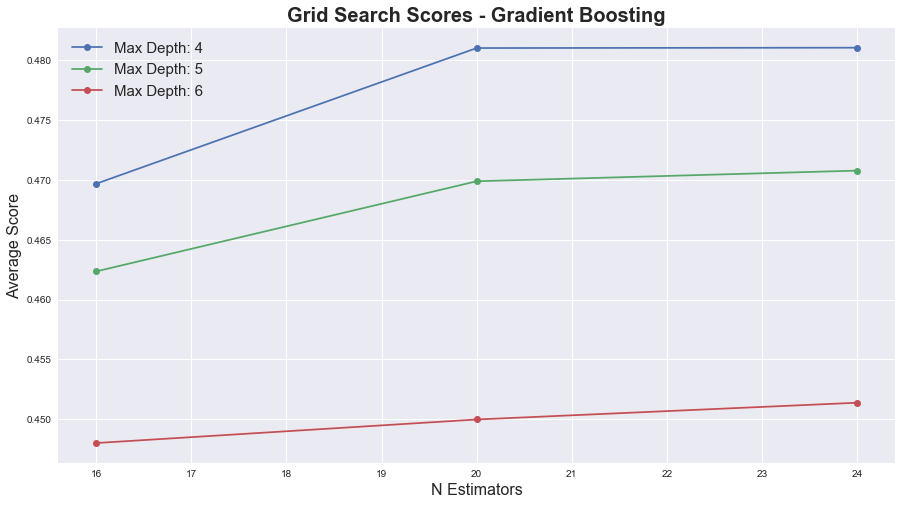

In [114]:
def plot_grid_search(cv_results, grid_param_1, grid_param_2, name_param_1, name_param_2):
    # Get Test Scores Mean and std for each grid search
    scores_mean = cv_results['mean_test_score']
    scores_mean = np.array(scores_mean).reshape(len(grid_param_2),len(grid_param_1))

    scores_sd = cv_results['std_test_score']
    scores_sd = np.array(scores_sd).reshape(len(grid_param_2),len(grid_param_1))

    # Plot Grid search scores
    fig, ax = plt.subplots(1,1, figsize = (15, 8))

    # Param1 is the X-axis, Param 2 is represented as a different curve (color line)
    for idx, val in enumerate(grid_param_2):
        ax.plot(grid_param_1, scores_mean[idx,:], '-o', label= name_param_2 + ': ' + str(val))

    ax.set_title("Grid Search Scores - Gradient Boosting", fontsize=20, fontweight='bold')
    ax.set_xlabel(name_param_1, fontsize=16)
    ax.set_ylabel('Average Score', fontsize=16)
    ax.legend(loc="best", fontsize=15)
    ax.grid('on')

# Calling Method 
plot_grid_search(grid_search.cv_results_, gb_grid_n_est, gb_grid_max_d, 'N Estimators', 'Max Depth')

#### Feature Importance

Below, I've returned the calculated feature importance of the baseline GB model and optimized GB model, respectively. They have very similar results between each other. And like the RF model earlier, distance has by far the most significant impact on the regression model.

In [115]:
returned_gb = MyGBRegression(all_variables, cab_type_global, ride_type_global, 100, None, 3, 1)

returned_gb = returned_gb.feature_importance()
returned_gb

Variable: distance             Importance: 0.9
Variable: time                 Importance: 0.04
Variable: windSpeed            Importance: 0.02
Variable: temperature          Importance: 0.01
Variable: precipIntensity      Importance: 0.01
Variable: humidity             Importance: 0.01
Variable: weekday              Importance: 0.0
Variable: price                Importance: 0.0


[None, None, None, None, None, None, None, None]

In [116]:
returned_gb = MyGBRegression(all_variables, cab_type_global, ride_type_global, rs_param[0],rs_param[1],rs_param[2],rs_param[3])

returned_gb = returned_gb.feature_importance()
returned_gb

Variable: distance             Importance: 0.9
Variable: windSpeed            Importance: 0.03
Variable: time                 Importance: 0.03
Variable: temperature          Importance: 0.01
Variable: precipIntensity      Importance: 0.01
Variable: humidity             Importance: 0.01
Variable: weekday              Importance: 0.0
Variable: price                Importance: 0.0


[None, None, None, None, None, None, None, None]

#### Summarize Performance Metrics of Model

Next, I compiled the regession model performance metrics into a dataframe - as done for the models tested earlier.

In [117]:
def gb_performance_metrics(cab_type, ride_type):


    
    ###parameter values trained and tested on sample dataset, simple (one variable) regression
    reg_simple_list = ['GB Simple Regression - Baseline']
    reg_simple = MyGBRegression(single_var, cab_type,ride_type,10, None, None, 1)
    reg_simple_list.append(reg_simple.metric_r2())
    reg_simple_list.append(reg_simple.metric_MAE())
    reg_simple_list.append(reg_simple.metric_MSE())
    reg_simple_list.append(reg_simple.metric_RMSE())
    reg_simple_list.append(reg_simple.metric_adj_r2())
    ##metrics on training dataset
    reg_simple_list.append(reg_simple.metric_r2_train())
    reg_simple_list.append(reg_simple.metric_MAE_train())
    reg_simple_list.append(reg_simple.metric_MSE_train())
    reg_simple_list.append(reg_simple.metric_RMSE_train())
    reg_simple_list.append(reg_simple.metric_adj_r2_train())
    simple_df_baseline_samp = pd.DataFrame(np.asarray(reg_simple_list).reshape(1,11), 
                                    columns = ['Regression Type','r2', 'MAE', 'MSE', 'RMSE', 
                                                'Adj_R2','r2_train', 'MAE_train', 'MSE_train', 
                                                'RMSE_train', 'Adj_R2_train'])

    ###parameter values trained and tested on sample dataset, all-variable regression
    reg_multi_list = ['GB Multivariate Baseline Parameters']
    reg_multi = MyGBRegression(all_variables, cab_type,ride_type, 10, None, None, 1)
    reg_multi_list.append(reg_multi.metric_r2())
    reg_multi_list.append(reg_multi.metric_MAE())
    reg_multi_list.append(reg_multi.metric_MSE())
    reg_multi_list.append(reg_multi.metric_RMSE())
    reg_multi_list.append(reg_multi.metric_adj_r2())
   ##metrics on training dataset
    reg_multi_list.append(reg_multi.metric_r2_train())
    reg_multi_list.append(reg_multi.metric_MAE_train())
    reg_multi_list.append(reg_multi.metric_MSE_train())
    reg_multi_list.append(reg_multi.metric_RMSE_train())
    reg_multi_list.append(reg_multi.metric_adj_r2_train())
    multi_df_baseline_samp = pd.DataFrame(np.asarray(reg_multi_list).reshape(1,11), 
                                            columns = ['Regression Type','r2', 'MAE', 'MSE', 'RMSE', 
                                                'Adj_R2','r2_train', 'MAE_train', 'MSE_train', 
                                                'RMSE_train', 'Adj_R2_train'])
    
    reg_multi_list = ['GB Multivariate Improved RandomSearch Parameters']
    reg_multi = MyGBRegression(all_variables, 
                               cab_type,ride_type, rs_param[0],rs_param[1],rs_param[2],rs_param[3])
    reg_multi_list.append(reg_multi.metric_r2())
    reg_multi_list.append(reg_multi.metric_MAE())
    reg_multi_list.append(reg_multi.metric_MSE())
    reg_multi_list.append(reg_multi.metric_RMSE())
    reg_multi_list.append(reg_multi.metric_adj_r2())
    
    reg_multi_list.append(reg_multi.metric_r2_train())
    reg_multi_list.append(reg_multi.metric_MAE_train())
    reg_multi_list.append(reg_multi.metric_MSE_train())
    reg_multi_list.append(reg_multi.metric_RMSE_train())
    reg_multi_list.append(reg_multi.metric_adj_r2_train())
    multi_df_improved_samp = pd.DataFrame(np.asarray(reg_multi_list).reshape(1,11), 
                                            columns = ['Regression Type','r2', 'MAE', 'MSE', 'RMSE', 
                                                'Adj_R2','r2_train', 'MAE_train', 'MSE_train', 
                                                'RMSE_train', 'Adj_R2_train'])

    reg_multi_list = ['GB Multivariate Optimal GridSearch Parameters']
    reg_multi = MyGBRegression(all_variables, 
                               cab_type,ride_type, params[0],params[1],params[2],params[3])
    reg_multi_list.append(reg_multi.metric_r2())
    reg_multi_list.append(reg_multi.metric_MAE())
    reg_multi_list.append(reg_multi.metric_MSE())
    reg_multi_list.append(reg_multi.metric_RMSE())
    reg_multi_list.append(reg_multi.metric_adj_r2())
    
    reg_multi_list.append(reg_multi.metric_r2_train())
    reg_multi_list.append(reg_multi.metric_MAE_train())
    reg_multi_list.append(reg_multi.metric_MSE_train())
    reg_multi_list.append(reg_multi.metric_RMSE_train())
    reg_multi_list.append(reg_multi.metric_adj_r2_train())
    multi_df_optimal_samp = pd.DataFrame(np.asarray(reg_multi_list).reshape(1,11), 
                                            columns = ['Regression Type','r2', 'MAE', 'MSE', 'RMSE', 
                                                'Adj_R2','r2_train', 'MAE_train', 'MSE_train', 
                                                'RMSE_train', 'Adj_R2_train'])

    reg_simple_list = ['GB Simple Regression - Optimal']
    reg_simple = MyGBRegression(single_var, cab_type,ride_type,params[0],None,params[2],params[3])
    reg_simple_list.append(reg_simple.metric_r2())
    reg_simple_list.append(reg_simple.metric_MAE())
    reg_simple_list.append(reg_simple.metric_MSE())
    reg_simple_list.append(reg_simple.metric_RMSE())
    reg_simple_list.append(reg_simple.metric_adj_r2())

    ##metrics on training dataset
    reg_simple_list.append(reg_simple.metric_r2_train())
    reg_simple_list.append(reg_simple.metric_MAE_train())
    reg_simple_list.append(reg_simple.metric_MSE_train())
    reg_simple_list.append(reg_simple.metric_RMSE_train())
    reg_simple_list.append(reg_simple.metric_adj_r2_train())

    simple_df_optimal_samp = pd.DataFrame(np.asarray(reg_simple_list).reshape(1,11), 
                                            columns = ['Regression Type','r2', 'MAE', 'MSE', 'RMSE', 
                                                'Adj_R2','r2_train', 'MAE_train', 'MSE_train', 
                                                'RMSE_train', 'Adj_R2_train'])

    
    all_dfs = [simple_df_baseline_samp, multi_df_baseline_samp, multi_df_improved_samp, multi_df_optimal_samp, simple_df_optimal_samp]
    all_results_df = pd.concat(all_dfs).reset_index(drop = True)
    return all_results_df

In [118]:
gb_performance_df = gb_performance_metrics(cab_type_global, ride_type_global)
gb_performance_df


Regression Type     r2    MAE    MSE  \
0                   GB Simple Regression - Baseline  0.479  2.053  7.595   
1               GB Multivariate Baseline Parameters  0.276   2.39  10.56   
2  GB Multivariate Improved RandomSearch Parameters  0.541  1.986  6.697   
3     GB Multivariate Optimal GridSearch Parameters  0.547  1.967  6.616   
4                    GB Simple Regression - Optimal  0.559  1.935  6.432   

    RMSE Adj_R2 r2_train MAE_train MSE_train RMSE_train Adj_R2_train  
0  2.756  0.479    0.518     2.058     7.559      2.749        0.518  
1   3.25  0.266    0.878     1.021     1.906      1.381        0.878  
2  2.588  0.534    0.572     1.932     6.707       2.59         0.57  
3  2.572   0.54    0.562     1.962     6.861      2.619        0.561  
4  2.536  0.559    0.531     2.003     7.344       2.71        0.531

The results above show that, once again, the simple regression model (with only distance as a predictor) performed the best. Similar to RF, the model with baseline parameters was greatly overfitted on the training data.  This is illusrated by the learning curve plots further below.

#### Plot Error Residuals

The distribution of the error residuals is below. The distribution of errors in GB is more normalized around 0 than the other models. 

In [119]:
# Plot residuals
def plot_residual(cab_type, ride_type):
    
    fig, (ax1, ax2) = plt.subplots (1,2, figsize=(20,6))    
    variables = all_variables
    lin_reg_simple = MyGBRegression(variables,cab_type,ride_type, params[0], params[1], params[2], params[3])
    X_train, X_test, y_train, y_test = lin_reg_simple.split_data()

#     X_train = X_train[:, 0] ##convert to series
#     X_train = np.array(X_train)
#     X_train = X_train[:,np.newaxis]
#     y_train = np.array(y_train)

#     X_test = X_test[:, 0] ##convert to series
#     X_test = np.array(X_test)
#     y_test = np.array(y_test)

    model = GradientBoostingRegressor(n_estimators = params[0], max_features = params[1], 
            max_depth = params[2], min_samples_leaf = params[3], random_state = 0)

    model.fit(X_train, y_train)
    # predict y from the data
    x_new = X_test
#     y_new = model.predict(X_test[:, np.newaxis])
    y_new = model.predict(X_test)
    
    ax1.scatter(y_new, y_new - y_test, c = "blue", marker = "s", label = "Training data", alpha = 0.1)
    # plt.scatter(y_test_pred, y_test_pred - y_test, c = "lightgreen", marker = "s", label = "Validation data")
    ax1.set_title("Residual of Multivariate GB Regression Errors")
    ax1.set_xlabel("Predicted values")
    ax1.set_ylabel("Residuals")
    ax1.legend(loc = "upper left")
    ax1.hlines(y = 0, xmin = 0, xmax = 20, color = "red")

    ax2.hist(y_new - y_test)
    ax2.set_title("Distribution of Residuals")
    ax2.set_xlabel("Residual")
    ax2.set_ylabel("Count")

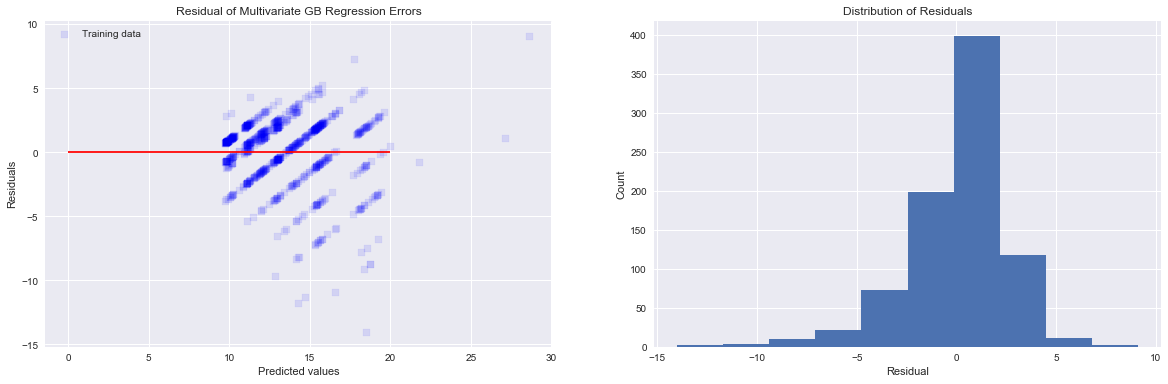

In [120]:
plot_residual(cab_type_global, ride_type_global)

In [121]:


def plot_learning_curves_gb(X, y, n_estimators, max_features, max_depth,min_samples_leaf):
    reg_simple_df = MyGBRegression(all_variables, cab_type_global,ride_type_global,10, None, None, 1)
    X_train, X_val, y_train, y_val = reg_simple_df.split_data()
    train_errors, val_errors = [], []
    for m in range(1, 300):
#         model_cab = neighbors.KNeighborsRegressor(n_neighbors = self.K)
#         model_cab.fit(X_train, y_train)
        model = GradientBoostingRegressor(n_estimators = 10, max_features = None, 
            max_depth = None, min_samples_leaf = 1, random_state = 0)
        model.fit(X_train[:m], y_train[:m])
        y_train_predict = model.predict(X_train[:m])
        y_val_predict = model.predict(X_val)
        train_errors.append(metrics.mean_squared_error(y_train[:m], y_train_predict))
        val_errors.append(metrics.mean_squared_error(y_val, y_val_predict))
    plt.figure(figsize = (15,9))
    plt.plot(np.sqrt(train_errors), "r-+", linewidth=2, label="train")
    plt.plot(np.sqrt(val_errors), "b-", linewidth=3, label="val")
    plt.title('Learning Curve')
    plt.xlabel('Number of Samples')
    plt.ylabel('RMSE')
    plt.legend(loc = 'upper right')
    return plt.plot()


#### Learning Curves of Training/Validation Data

The learning curve below is based on the GB model using baseline paramater values. Similar to RF, the model is significantly overfitted to the training data

[]

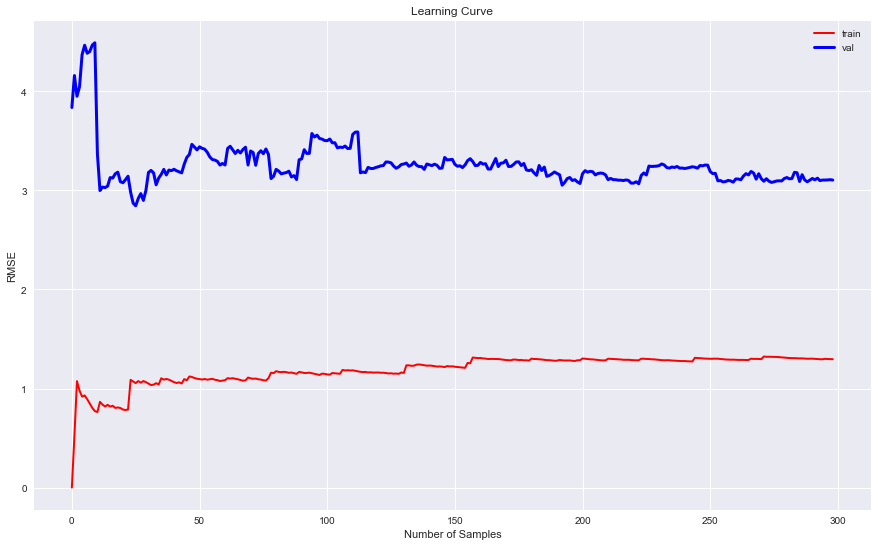

In [122]:
reg_simple_df = MyGBRegression(all_variables, cab_type_global,ride_type_global,10, None, None, 1)
return_x = reg_simple_df.filter_data()
return_x = return_x.loc[:, return_x.columns != target[0]]

X = return_x
y = df_sample[target]
plot_learning_curves_gb(X, y,params[0],params[1],params[2],params[3])


## Final Results

All of that hard work has finally led us to this point - the final comparison of performance between models.
The dataframe below compiles all the performance metrics across each model we tested above. It is sorted in order of highest Adjusted R-Squared scoer. And the winner is.....

Gradient Boosting Simple Regression!!!

This performance of this model slightly edged out Simple Random Forest and Simple kNN. A key takeway is that the simple regression models generally outperformed the multivariate ones. It is very clear is the most significant predictor of Ride Share price, and other attributes have very minimal impact, if at any. 

In [123]:
all_model_results = pd.concat([linear_performance_df, knn_performance_df, rf_performance_df, gb_performance_df]).reset_index(drop = True)
all_model_results.sort_values(by = ['Adj_R2'], ascending = False).reset_index(drop = True)

Regression Type     r2    MAE    MSE  \
0                     GB Simple Regression - Optimal  0.559  1.935  6.432   
1                   Simple kNN: Optimized Paramaters  0.558  1.892  6.442   
2          Simple Random Forest - Optimal Parameters  0.558  1.931  6.452   
3    Multivariate Random Forest - Optimal Parameters  0.555  1.948  6.495   
4   Multivariate Random Forest - Improved Parameters  0.552  1.949  6.531   
5                              Polynomial Regression  0.545  1.948  6.637   
6      GB Multivariate Optimal GridSearch Parameters  0.547  1.967  6.616   
7                               Quadratic Regression   0.54  1.952  6.707   
8                           Simple Linear Regression  0.536  1.977  6.771   
9   GB Multivariate Improved RandomSearch Parameters  0.541  1.986  6.697   
10                        Multiple Linear Regression  0.532  1.991   6.83   
11        Simple Random Forest - Baseline Parameters  0.524  1.936  6.941   
12                   Simple kNN: Baseline Paramaters  0.502  1.994  7.271   
13                   GB Simple Regression - Baseline  0.479  2.053  7.595   
14            Multivariate kNN: Optimized Paramaters   0.46  2.083  7.884   
15  Multivariate Random Forest - Baseline Parameters  0.456  2.087  7.938   
16             Multivariate kNN: Baseline Paramaters  0.417  2.174  8.512   
17               GB Multivariate Baseline Parameters  0.276   2.39  10.56   

     RMSE Adj_R2 r2_train MAE_train MSE_train RMSE_train Adj_R2_train  
0   2.536  0.559    0.531     2.003     7.344       2.71        0.531  
1   2.538  0.558    0.537     1.966     7.254      2.693        0.537  
2    2.54  0.557    0.524     2.001     7.455       2.73        0.524  
3   2.549  0.548    0.534     1.986     7.303      2.702        0.532  
4   2.556  0.546    0.555     1.948     6.968       2.64        0.554  
5   2.576  0.544    0.498     2.022     7.862      2.804        0.498  
6   2.572   0.54    0.562     1.962     6.861      2.619        0.561  
7    2.59  0.539    0.495     2.029     7.913      2.813        0.495  
8   2.602  0.535    0.493     2.045      7.94      2.818        0.493  
9   2.588  0.534    0.572     1.932     6.707       2.59         0.57  
10  2.613  0.525    0.495     2.043     7.915      2.813        0.493  
11  2.635  0.524    0.579     1.872     6.593      2.568        0.579  
12  2.696  0.501    0.514     2.002     7.618       2.76        0.514  
13  2.756  0.479    0.518     2.058     7.559      2.749        0.518  
14  2.808  0.459     0.53     1.952     7.364      2.714         0.53  
15  2.818  0.448    0.887      0.89     1.772      1.331        0.887  
16  2.917  0.416    0.595     1.802     6.343      2.518        0.595  
17   3.25  0.266    0.878     1.021     1.906      1.381        0.878

In [96]:
os.system('jupyter nbconvert --to html Ride Sharing Prices_v2.ipynb')
# !jupyter nbconvert --to html Ride_Sharing.ipynb

-1